# Hierarchical Photometric Redshift Inference

Part 4 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook outlines how to modify the photometric posteriors showcased in Part 3.1 and 3.2 in the context of the **hierarchical Bayesian model** illustrated in Part 2.

## Setup

In [1]:
import sys # system commands
import pickle # saving data
from scipy import stats # statistics functions
from scipy import special # special functions
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation
from pandas.tools.plotting import autocorrelation_plot # autocorrelation plot

# simulation
import make_sim as sim

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Data

As before, we will use our mock SDSS data to benchmark our tests here.

In [2]:
sdss = pickle.load(open( "data/mock_sdss_cosmos_bpz.p", "rb" )) # load data
[types, redshifts, mags], templates = sdss.samples, sdss.samples_t # import truth labels

Let's now initialize our catalogs and compute our fits. We'll apply the same selection functions as Parts 3.2 and 3.3 for consistency.

In [3]:
# dividing into training/testing samples
Nobs = sdss.NSAMPLES
Ntrain, Ntest = 100000, 20000

sel_train = arange(Nobs)[sdss.phot_obs[:,2] / sdss.noise[:,2] > 2.] # r-band S/N>2 cut
train_sel = sel_train[:Ntrain] # training set

sel_test = arange(Nobs)[sdss.phot_obs[:,2] / sdss.noise[:,2] > 10.] # r-band S/N>10 cut
test_sel = sel_test[sel_test>train_sel[-1]][:Ntest] # testing set

print 'Number of observed galaxies (all):', Nobs
print 'Number of training galaxies:', Ntrain
print 'Number of testing galaxies:', Ntest

Number of observed galaxies (all): 500000
Number of training galaxies: 100000
Number of testing galaxies: 20000


In [4]:
# initializing photometry
phot_train, phot_test = sdss.phot_obs[train_sel], sdss.phot_obs[test_sel]
err_train, err_test = sdss.noise[train_sel], sdss.noise[test_sel]
pkern = ones(sdss.NFILTER)*0.05 # photometric Gaussian kernel (smoothing)
err_train_smooth = sqrt(err_train**2 + (pkern*phot_train)**2) # add kernel to training objects

# initializing masks
mask = random.uniform(size=(Ntrain+Ntest, sdss.NFILTER)) > 0.01 # randomly censor 5% of observations
mask[:,2] = True # always detected in r-band (used for selection)
mask_train, mask_test = mask[:Ntrain], mask[Ntrain:Ntrain+Ntest]

csel_train, csel_test = mask_train.sum(axis=1) < sdss.NFILTER, mask_test.sum(axis=1) < sdss.NFILTER

print 'Number of censored training objects:', csel_train.sum()
print 'Number of censored testing objects:', csel_test.sum()

Number of censored training objects: 4118
Number of censored testing objects: 810


In [5]:
# initialize asinh magnitudes (Luptitudes)
flux_zeropoint = 10**(-0.4*-23.9) # AB magnitude zeropoint
mag, magerr = fz.asinh_mag_map(sdss.phot_obs, sdss.noise, # map f_nu to asinh mag
                               skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint) # softening parameter and zero-point

# read FRANKEN-Z config files (to get dictionaries)
config = fz.ReadParams('config/frankenz.config')

# initialize supplementary dictionaries
mdict = fz.PDFDict(config.CONFIG_MAG.params) # magnitude dict
cdict = fz.PDFDict(config.CONFIG_COLOR.params) # color dict
magidx, mageidx = mdict.fit(mag, magerr) # discretized magnitudes

In [6]:
# initialize redshift dictionary
rdict = fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict = rdict.lze_dict
rdict.sig_width = rdict.lze_width
rdict.delta = rdict.dlz_highres
rdict.grid = rdict.lzgrid_highres
rdict.Ngrid = rdict.Nz_highres

# discretize redshifts
lz, lze = log(1+redshifts), ones(Nobs)*rdict.dlz 
lzidx, lzeidx = rdict.fit(lz, lze) # discretized ln(1+z)
lz_train, lze_train = lz[train_sel], lze[train_sel]

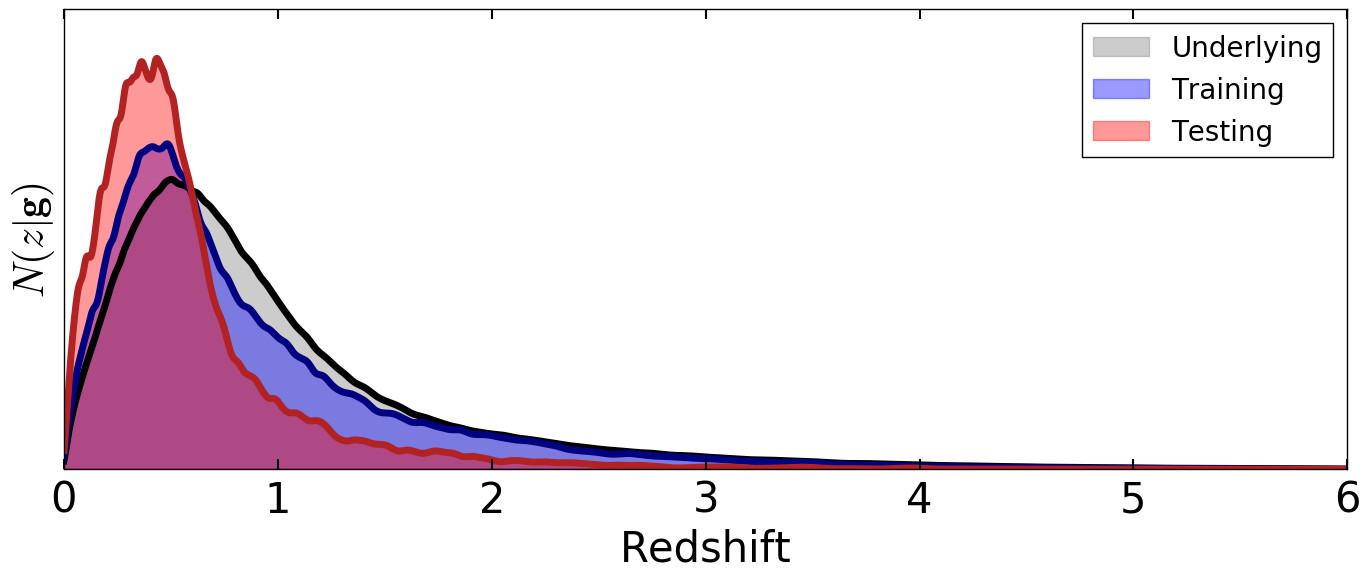

In [7]:
# plotting redshift distribution
figure(figsize=(14,6))

# all
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, ones(Nobs),
                       rdict.grid, rdict.delta, Nobs, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf /= z_pdf.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf, lw=5, color='black')
fill_between(rdict.zgrid_highres, z_pdf, color='gray', alpha=0.4, label='Underlying')

# training
z_pdf_train = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], ones(Ntrain),
                              rdict.grid, rdict.delta, Ntrain, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf_train = z_pdf_train[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf_train /= z_pdf_train.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf_train, lw=5, color='navy')
fill_between(rdict.zgrid_highres, z_pdf_train, color='blue', alpha=0.4, label='Training')

# testing
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[test_sel], lzeidx[test_sel], ones(Ntest),
                        rdict.grid, rdict.delta, Ntest, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf /= z_pdf.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf, lw=5, color='firebrick')
fill_between(rdict.zgrid_highres, z_pdf, color='red', alpha=0.4, label='Testing')

xlim([0, 6])
yticks([])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('$N(z|\mathbf{g})$')

## Fits

In [8]:
# initialize FRANKEN-Z instance
frankenz = fz.FRANKENZ(N_members=25, n_neighbors=10)

# initialize WINBET instance (training)
winbet_train = fz.WINBET(Ntrees=25) # 25 trees
winbet_train.train(phot_train, err_train, mask_train)

# initialize WINBET instance (testing)
winbet_test = fz.WINBET(Ntrees=25) # 25 trees
winbet_test.train(phot_test, err_test, mask_test)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [9]:
# compute log-likelihoods
model_obj, model_Nobj, model_ll, model_Nbands = frankenz.predict(phot_train, err_train_smooth, mask_train, 
                                                                 phot_test, err_test, mask_test, 
                                                                 impute_train=winbet_train, impute_targ=winbet_test)

(0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10) (11) (12) (13) (14) (15) (16) (17) (18) (19) (20) (21) (22) (23) (24) 0 5000 10000 15000 done!


In [10]:
# compute evidences and posteriors
model_post = zeros(model_ll.shape)
model_evid = zeros(Ntest)
prior = ones(Ntrain) # uniform prior

for i in arange(Ntest):
    Nm = model_Nobj[i] # number of models
    midx = model_obj[i,:Nm] # model indices
    ll = model_ll[i,:Nm] # log-likelihoods
    like = exp(-0.5*(ll-ll.min())) # scaled likelihoods
    model_evid[i] = like.sum() * exp(-0.5*ll.min()) # evidence
    post = float64(like * prior[midx]) # scaled posteriors
    post /= post.sum() # normalizing
    model_post[i,:Nm] = post

### Sidenote: Coverage

Before we move on, we want to check (and possibly remove) objects whose likelihoods/posteriors are essentially garbage (i.e. they have no coverage in our basis). In Part 2, we outlined how this can done using an object's overall evidence. We now use that metric to screen out objects whose posteriors are not well-sampled enough for our purposes.

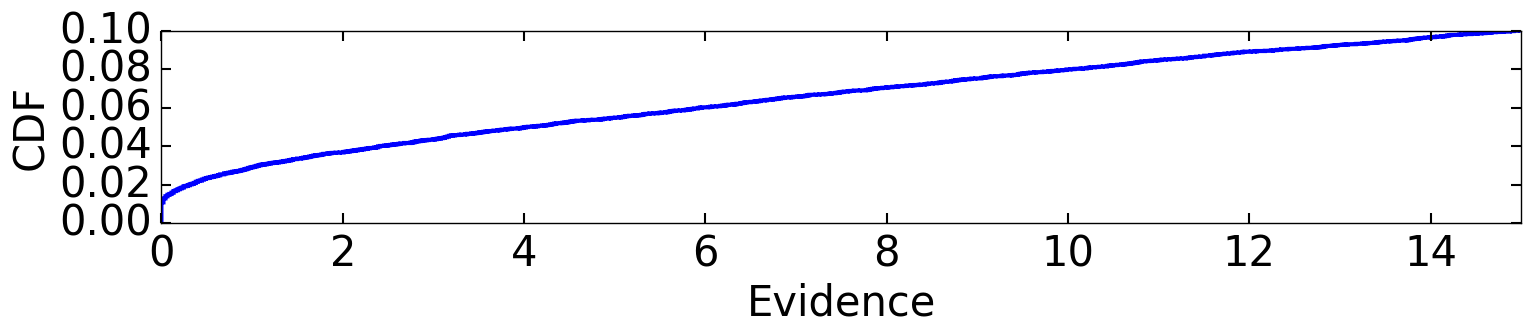

In [12]:
figure(figsize=(16,4))
h = hist(model_evid, 50000, histtype='step', lw=3, normed=True, cumulative=True)
xlabel('Evidence')
xlim([0,15])
ylabel('CDF')
ylim([0,0.1])
tight_layout()

Only a small fraction of objects do not have any good fits, so it looks like our coverage here is excellent. Let's now flag objects that don't meet our coverage requirements.

In [13]:
pmask = arange(len(err_test))[model_evid>10]
Ntest = len(pmask)
print('Objects with reasonable coverage {:}/{:}'.format(Ntest, len(model_evid)))

Objects with reasonable coverage 18403/20000


We'll consider fits to those objects "unreliable" and exclude them from the rest of our inference.

In [14]:
# computing stacked posteriors
pstack = zeros(Ntrain)
for i in pmask:
    Nm = model_Nobj[i]
    midx = model_obj[i,:Nm]
    pstack[midx] += model_post[i,:Nm] # stacked posterior

In [15]:
# compute redshift PDF (truth)
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[test_sel][pmask], lzeidx[test_sel][pmask], ones(Ntest),
                        rdict.grid, rdict.delta, Ntest, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf = interp(rdict.zgrid_out, rdict.zgrid_highres, z_pdf)
z_pdf /= z_pdf.sum() # normalizing

## Population Inference: Poisson

In [16]:
Nsamples = 20 # number of samples

As before, we start out by assuming that our stacked posteriors over our data is an independent **Poisson (counting) process**, such that the errors for any particular training object are independent of each other and scale as $\sqrt{N}$. 

$$
\hat{N}_h \sim \textrm{Pois}(N|\lambda_h = \mathcal{Z}_h)
$$

where $\lambda_h$ is the associated concentration parameter and $\mathcal{Z}_h \equiv \sum_{g \in \mathbf{g}} P(h|g,s_g=1,\mathcal{S})$ is the stacked posterior for training object $h$.

In [17]:
pois_samples = array([poisson(pstack) for i in xrange(Nsamples)]) # samples

Let's check how our realized posterior evidence compares with our original estimates.

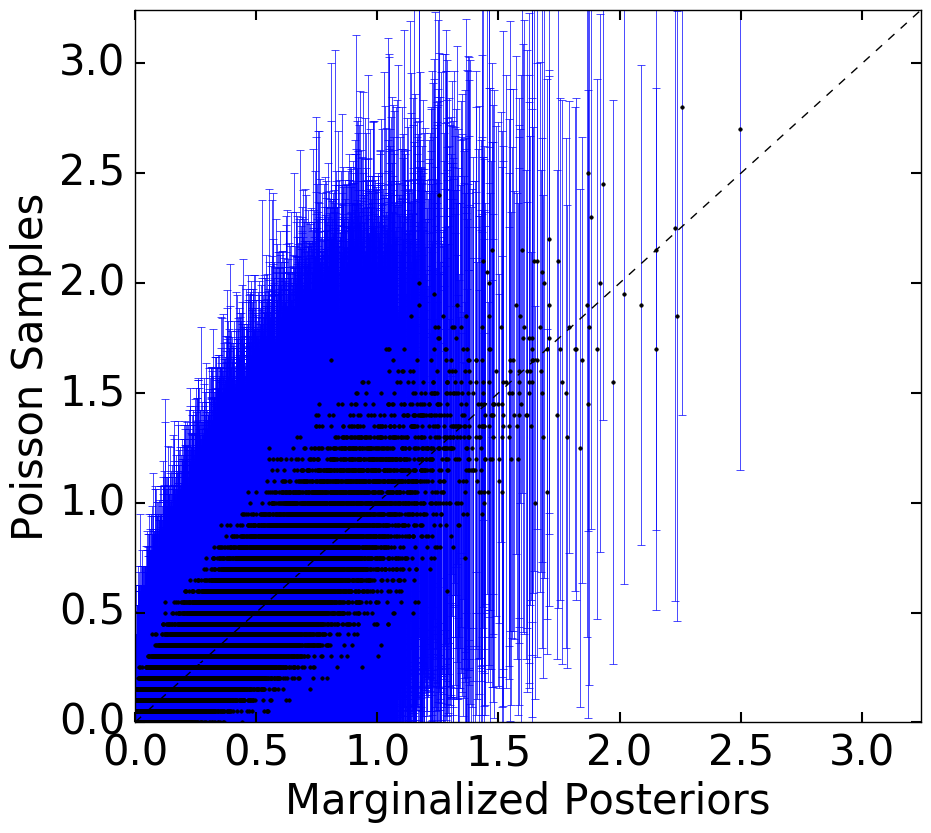

In [18]:
# plotting
figure(figsize=(10,9))
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, pois_samples.mean(axis=0), fmt='k.', yerr=pois_samples.std(axis=0), ecolor='blue', markersize=5, lw=0.5)
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Poisson Samples')
tight_layout()

As expected, the two agree! We now want to sample a set of redshifts from our Poisson samples over our training data.

In [19]:
# draw redshift samples
pois_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    Nsamps = pois_samples[i].sum()
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], pois_samples[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    pois_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    pois_samples_z[i] *= (Nsamps / pois_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

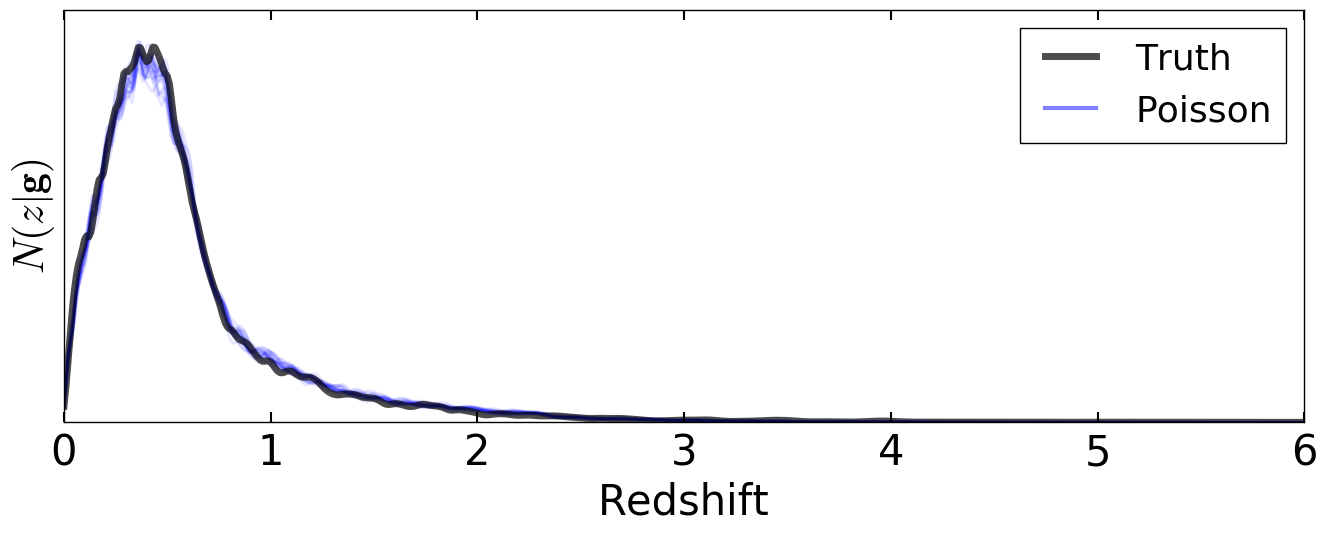

In [20]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, pois_samples_z[i], lw=2, color='blue', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
xlabel('Redshift')
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.1])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

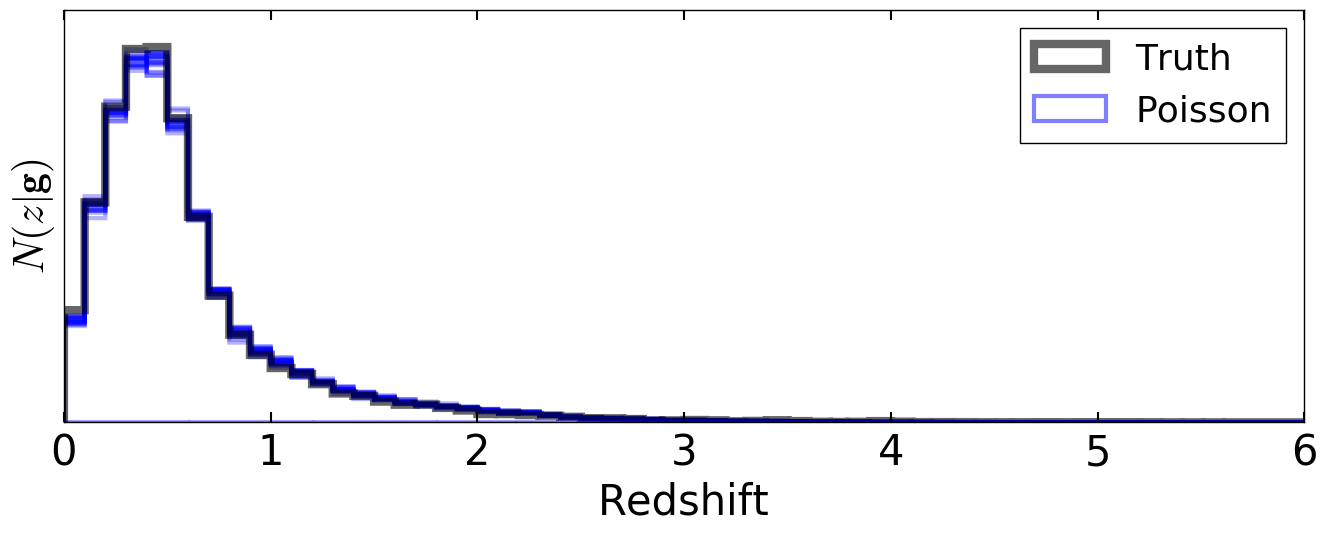

In [21]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=pois_samples_z[i], lw=3, histtype='step', color='blue', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='blue', alpha=0.5, label='Poisson')
xlabel('Redshift')
yticks([])
ylim([0, max(h[0]) * 1.1])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

## Population Inference: Multinomial

We now assume our population distribution $\mathbf{n} \equiv \lbrace \dots, N(h|\mathbf{g}), \dots \rbrace$ can be sampled from the **Multinomial distribution** as

$$
\mathbf{n} \sim \textrm{Mult}\left( n=N_g, \mathbf{p} = \mathbf{p}_\mathbf{h} \right)
$$

where $\mathbf{p}$ is the set of marginalized posteriors computed above. 

In [23]:
# draw object samples
mult_samples = multinomial(Ntest, pstack/pstack.sum(), size=Nsamples)

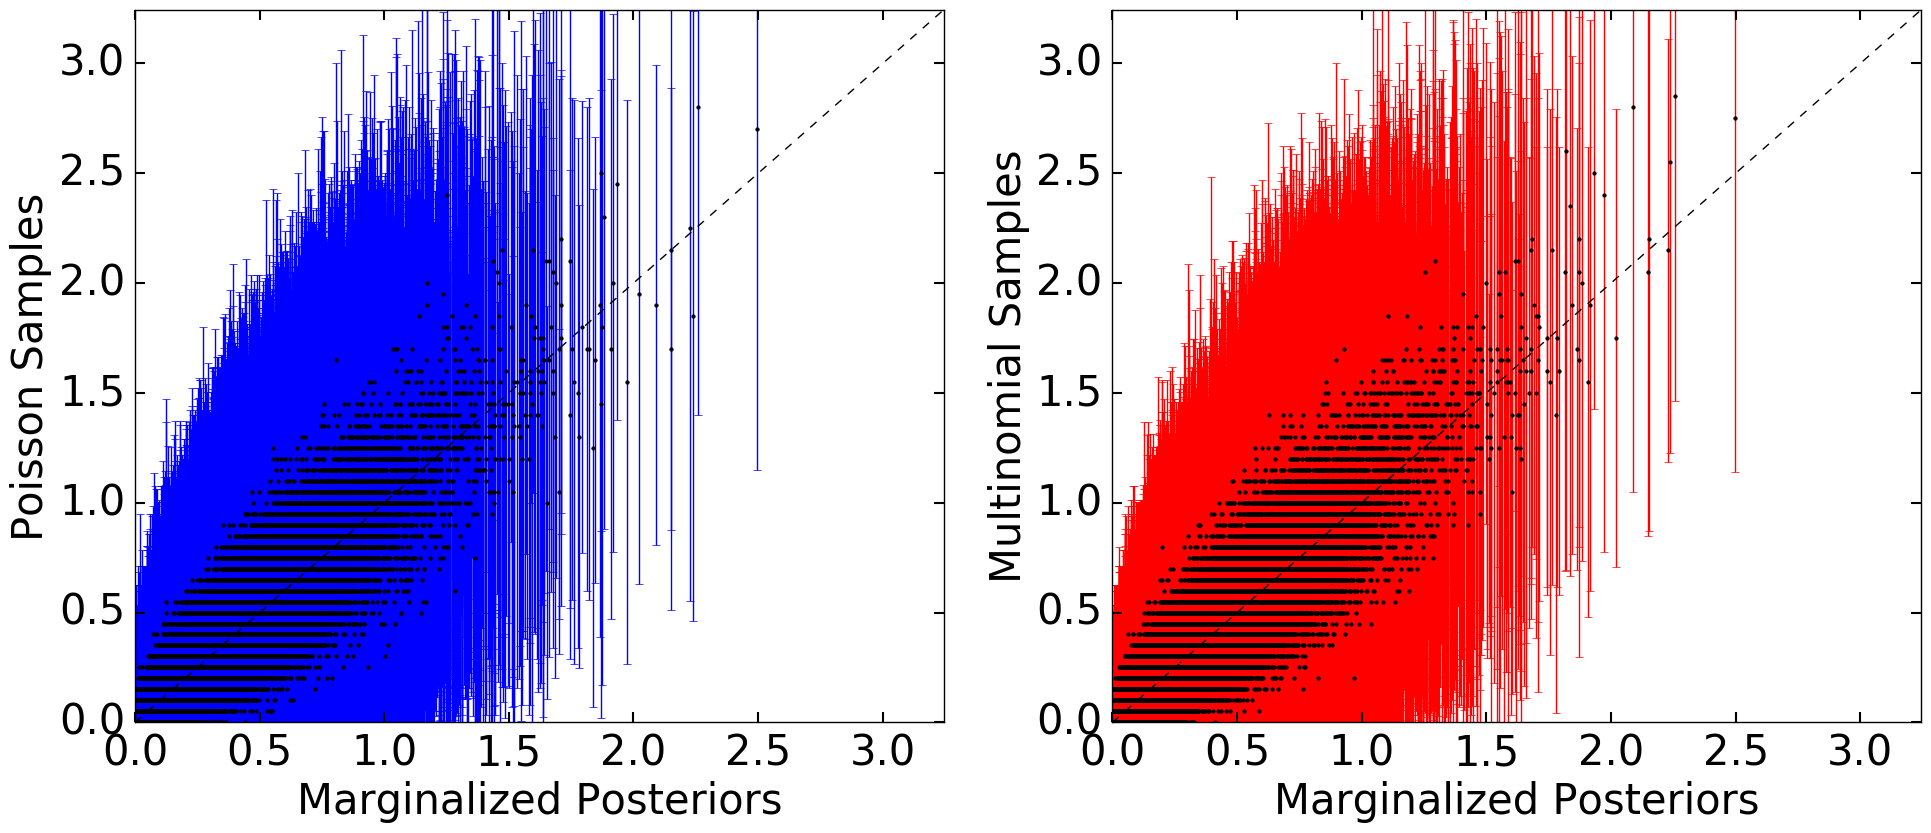

In [24]:
# plotting
figure(figsize=(20,9))
subplot(1,2,1)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, pois_samples.mean(axis=0), fmt='k.', yerr=pois_samples.std(axis=0), ecolor='blue', markersize=5, lw=1)
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Poisson Samples')
tight_layout()
subplot(1,2,2)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, mult_samples.mean(axis=0), fmt='k.', yerr=mult_samples.std(axis=0), ecolor='red', markersize=5, lw=1)
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Multinomial Samples')
tight_layout()

In [25]:
# draw redshift samples
mult_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], mult_samples[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    mult_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    mult_samples_z[i] *= (Ntest / mult_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

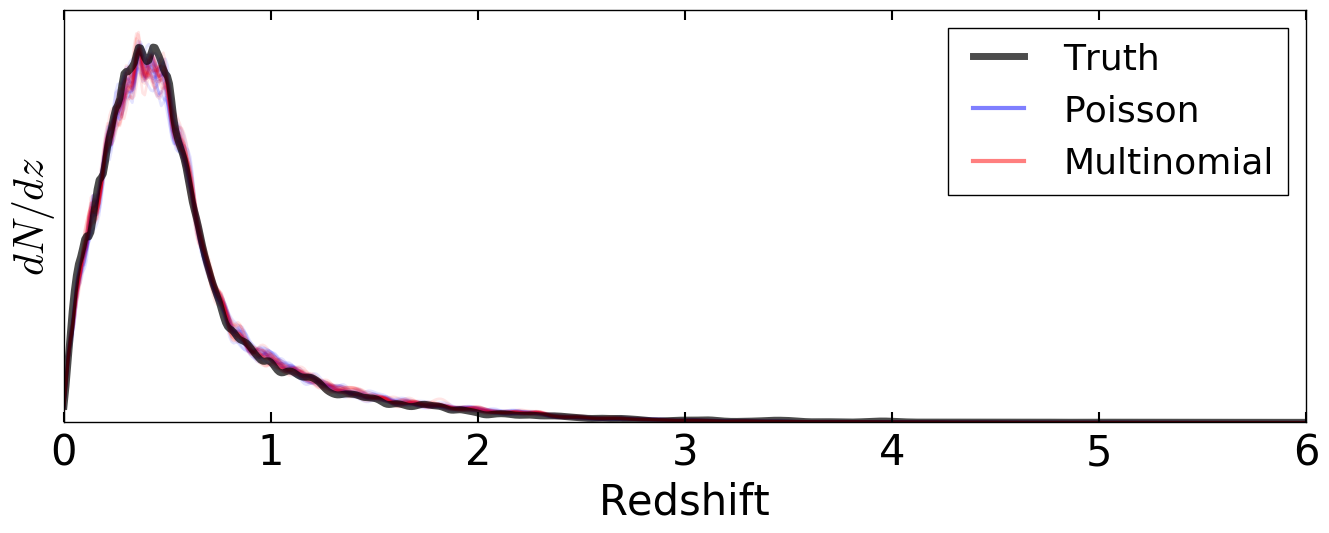

In [26]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, pois_samples_z[i], lw=2, color='blue', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, mult_samples_z[i], lw=2, color='red', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Multinomial')
xlabel('Redshift')
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.1])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

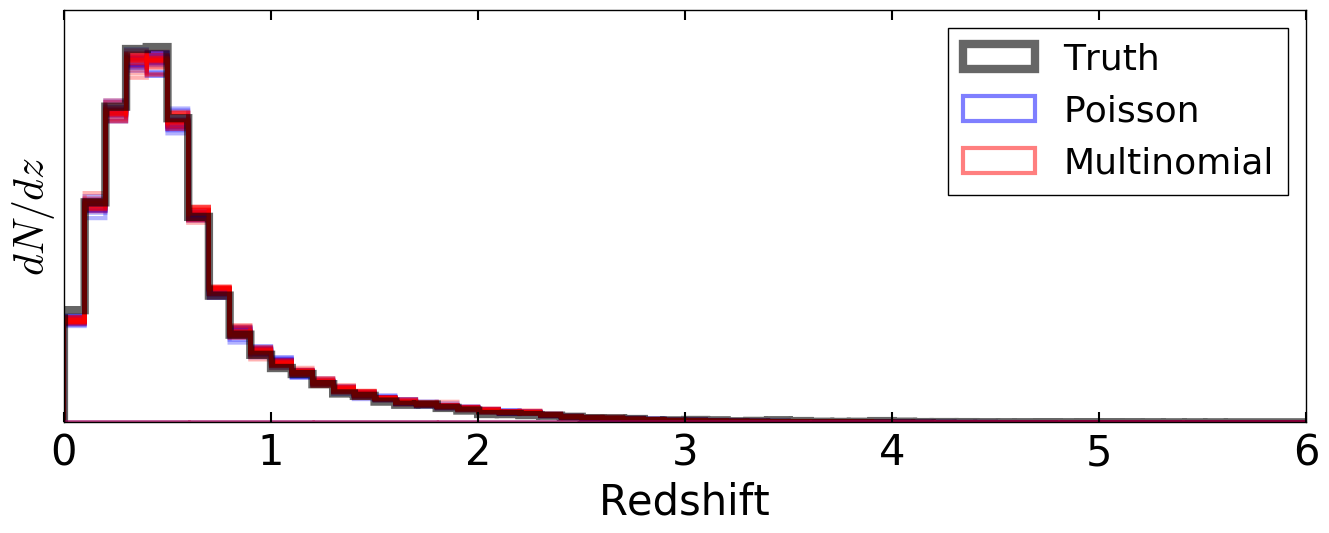

In [27]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=pois_samples_z[i], lw=3, histtype='step', color='blue', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=mult_samples_z[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='blue', alpha=0.5, label='Poisson')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Multinomial')
xlabel('Redshift')
yticks([])
ylim([0, max(h[0]) * 1.1])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

## Population Inference: Posterior

Our "Big Data" approximation considers the distribution of a particular galaxy $g$ over our training set $\mathbf{h}$ as

$$
h_g \sim \textrm{Mult} \left(n=1, \mathbf{p}=\mathbf{p}_g \right)
$$

where $\textrm{Mult}\left(n, \mathbf{p}\right)$ again the **Multinomial distribution** with $n$ draws from $N_p$ categories with corresponding probabilities $\mathbf{p}$ and $\mathbf{p}_g \equiv \lbrace \dots, P(h|g, s_g=1, \mathcal{S}) \dots \rbrace$ is the a $N_h \times 1$ vector containing our computed posteriors. Again, this is just the formal statement that there are $N_h$ discrete galaxy "types" that $\mathbf{g}$ can be with probability $P(h|g, s_g=1, \mathcal{S})$ of being any given one.

The number density $\mathbf{n}$ over our training data $\mathbf{h}$ is then

$$
\mathbf{n} \sim \sum_{g \in \mathbf{g}} \textrm{Mult} \left(n=1, \mathbf{p}=\mathbf{p}_g \right) \quad .
$$

As in Part 2, we can draw samples $\mathbf{n}^{(i)}$ from our posteriors by iteratively sampling from the underlying PDFs over $\mathbf{h}$ and then stacking the results.

In [28]:
post_samples = zeros((Nsamples, Ntrain), dtype='int')
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    for j in pmask:
        Nm = model_Nobj[j]
        midx = model_obj[j,:Nm]
        post = model_post[j,:Nm]
        post_samples[i,midx] += multinomial(1, post) # sample object

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

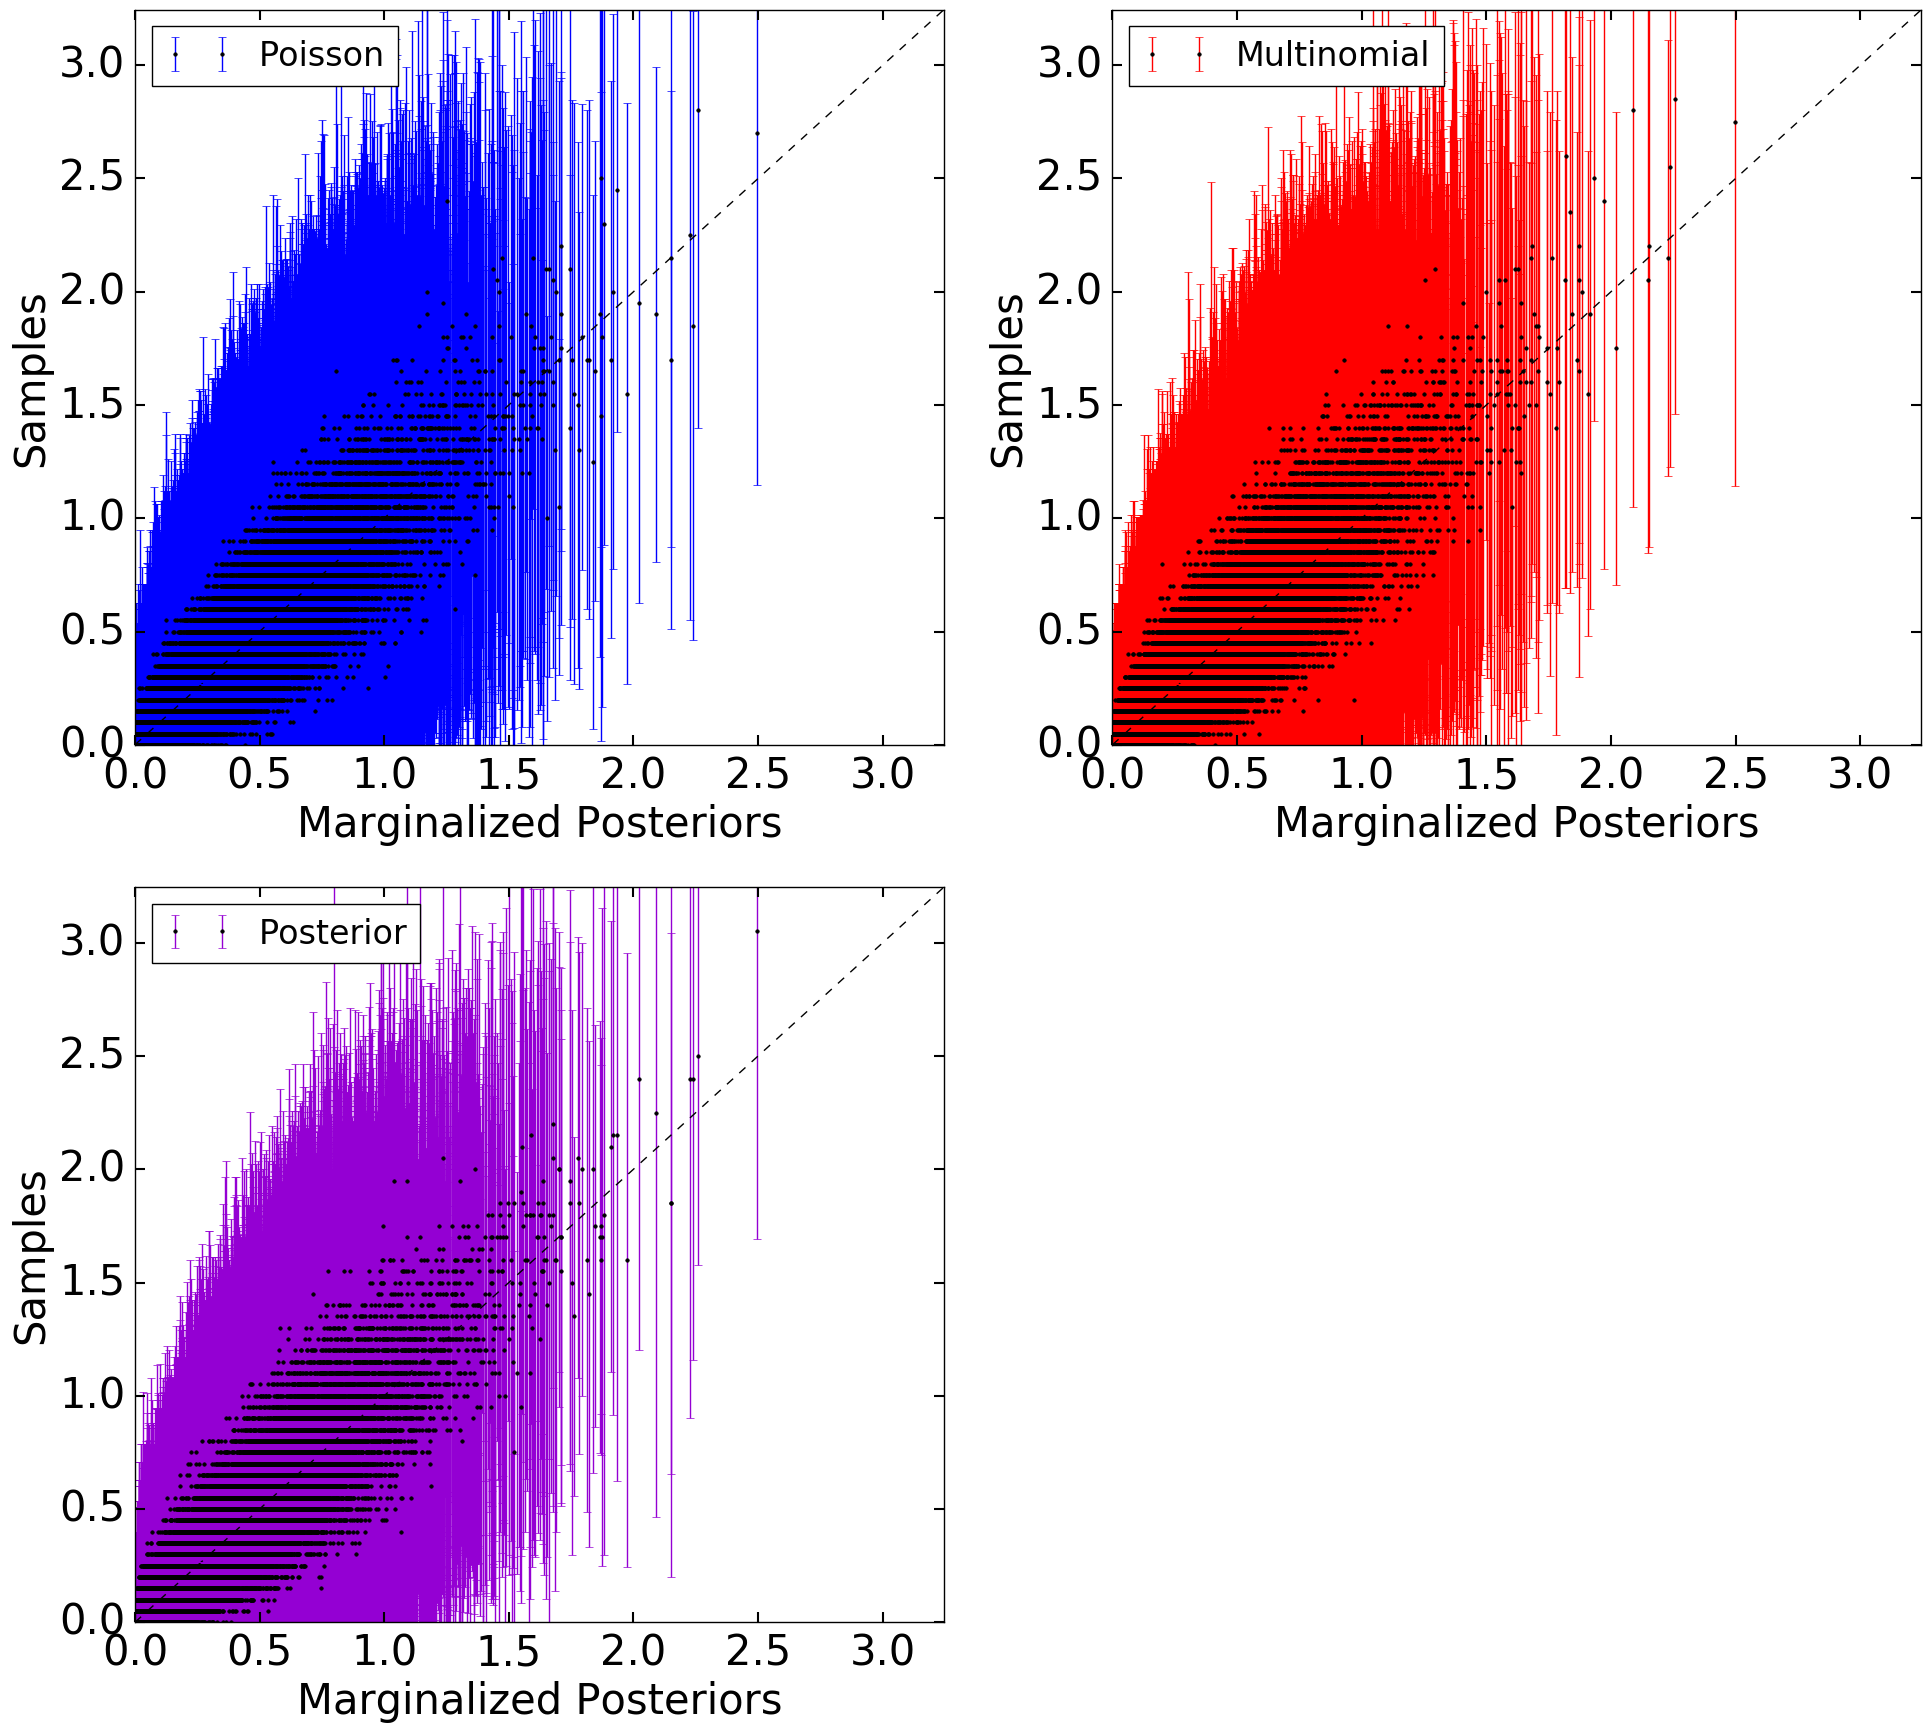

In [29]:
# plotting
figure(figsize=(20,18))
subplot(2,2,1)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, pois_samples.mean(axis=0), fmt='k.', yerr=pois_samples.std(axis=0), ecolor='blue', markersize=5, lw=1, 
         label='Poisson')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(2,2,2)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, mult_samples.mean(axis=0), fmt='k.', yerr=mult_samples.std(axis=0), ecolor='red', markersize=5, lw=1,
         label='Multinomial')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(2,2,3)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, post_samples.mean(axis=0), fmt='k.', yerr=post_samples.std(axis=0), ecolor='darkviolet', markersize=5, lw=1,
         label='Posterior')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()

Although the means are the same (by construction), the different errors now more accurately reflect the correlations present within the posteriors of each individual object (i.e. our stacked posteriors are not fully independent).

In [30]:
# draw redshift samples
post_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], post_samples[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    post_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    post_samples_z[i] *= (Ntest / post_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

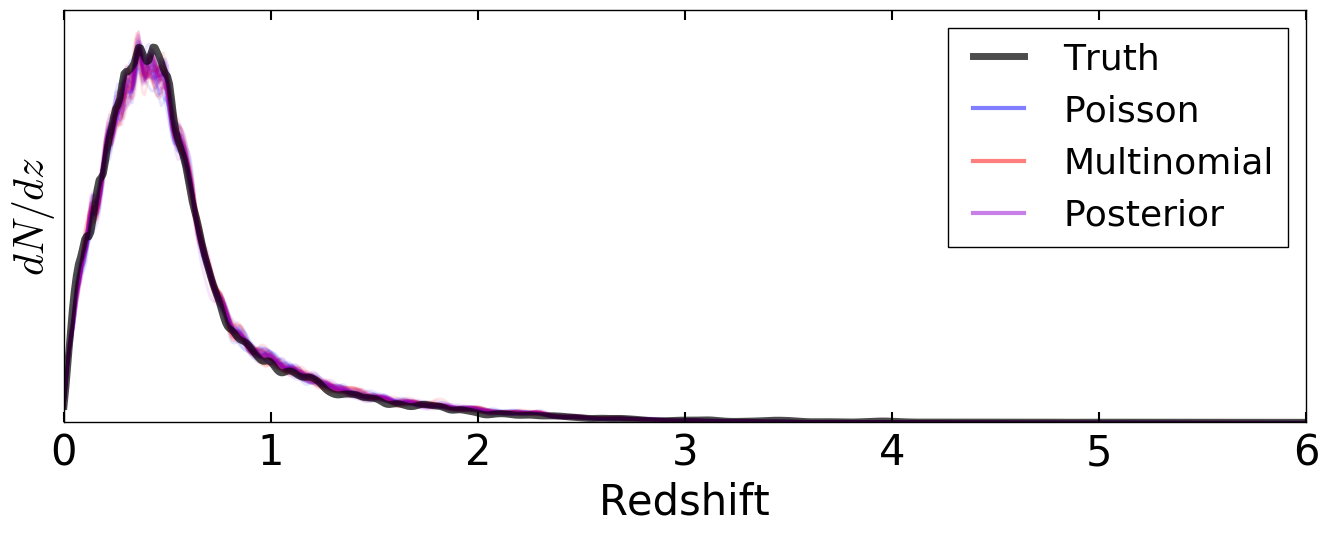

In [31]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, pois_samples_z[i], lw=2, color='blue', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, mult_samples_z[i], lw=2, color='red', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, post_samples_z[i], lw=2, color='darkviolet', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Multinomial')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Posterior')
xlabel('Redshift')
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.1])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

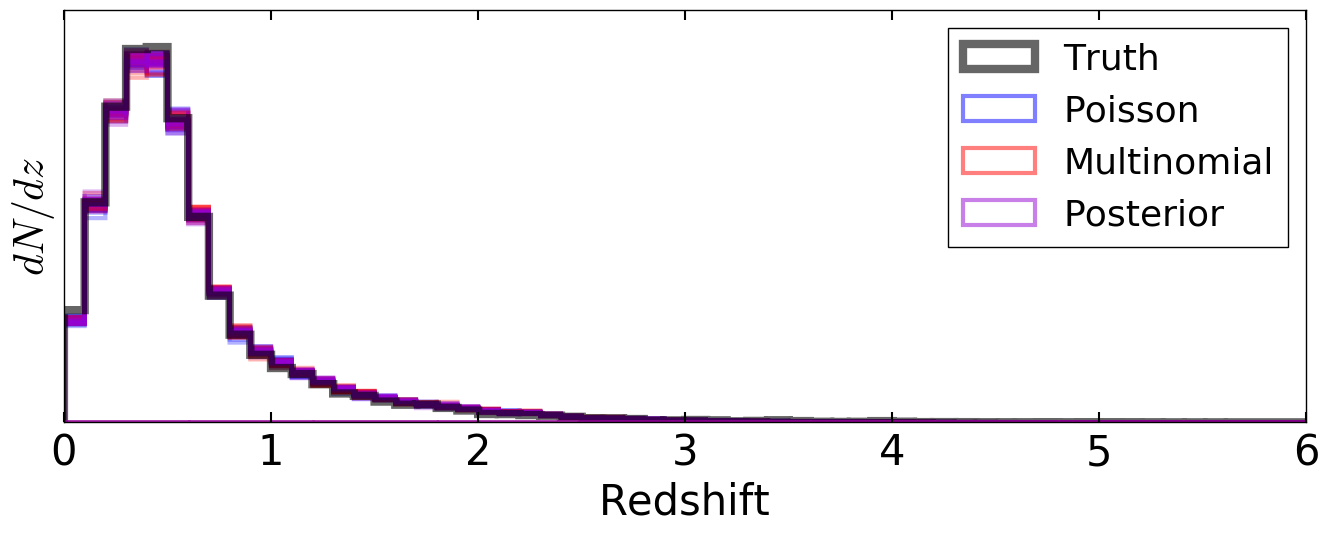

In [32]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=pois_samples_z[i], lw=3, histtype='step', color='blue', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=mult_samples_z[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=post_samples_z[i], lw=3, histtype='step', color='darkviolet', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='blue', alpha=0.5, label='Poisson')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Multinomial')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='darkviolet', alpha=0.5, label='Posterior')
xlabel('Redshift')
yticks([])
ylim([0, max(h[0]) * 1.1])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

## Hierarchical Inference

We want to sample from the **joint distribution** $P(\mathbf{w}, \lbrace \dots, \mathbf{p}_g, \dots \rbrace)$. 

As discussed in Part 2, this in general is intractable for typical Metropolis-style MCMC samplers that probe the joint distribution directly, but is particularly amenable to **Gibbs sampling**. We can thus sample from distribution by iteratively sampling from $P(\lbrace \dots, \mathbf{p}_g, \dots \rbrace | \mathbf{w})$ and $P(\mathbf{w} | \lbrace \dots, \mathbf{p}_g, \dots \rbrace)$. Assuming **Poisson independence** for all $g \in \mathbf{g}$, we can draw our posterior samples via

\begin{align}
\textrm{Sample individual objects:}& \quad \lbrace \dots, \mathbf{\hat{p}}_g^{(i)}, \dots \rbrace \sim \left\lbrace \dots, \textrm{Mult}\left( n=1, \mathbf{p}=\mathbf{p}_g \bullet \mathbf{w}^{(i-1)} \right), \dots \right\rbrace \\
\textrm{Compute number density:}& \quad \mathbf{n}^{(i)} = \sum_{g \in \mathbf{g}} \mathbf{\hat{p}}_g^{(i)} \\
\textrm{Sample population weights:}& \quad \mathbf{w}^{(i)} \sim \textrm{Dir}\left(\mathbf{w} | \mathbf{n}^{(i)} + 1\right) \quad .
\end{align}

In [33]:
# generate samples
Nmcmc = 200 # total number of MCMC draws
hier_samples_n = zeros((Nmcmc, Ntrain))
hier_samples_w = zeros((Nmcmc, Ntrain))

wt = ones(Ntrain) # initialize weights
for i in xrange(Nmcmc):
    sys.stdout.write(str(i)+' ')
    n = zeros(Ntrain) # number counts
    for j in pmask:
        Nm = model_Nobj[j]
        midx = model_obj[j,:Nm]
        post = model_post[j,:Nm] * wt[midx]
        post /= post.sum()
        n[midx] += multinomial(1, post) # stack multinomial draw
    wt = dirichlet(n + 1) * Ntest # sample population weight
    hier_samples_n[i], hier_samples_w[i] = n.copy(), wt.copy()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

Let's examine the autocorrelation of our chain to see how we're doing.

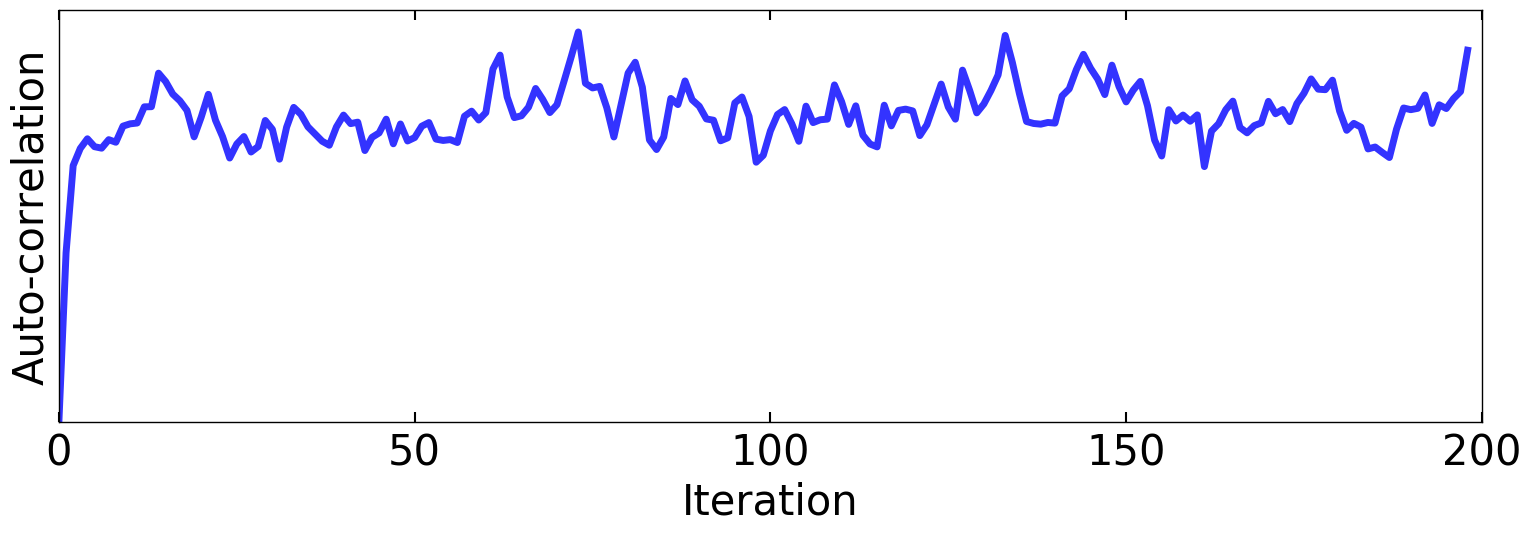

In [34]:
# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(hier_samples_n[i], hier_samples_n[i+1]) for i in arange(Nmcmc-1)]).flatten()
plot(arange(Nmcmc-1), autocorr, lw=5, color='blue', alpha=0.8, label='Original')
xlabel('Iteration')
ylabel('Auto-correlation')
yticks([])
xlim([0, Nmcmc])
tight_layout()

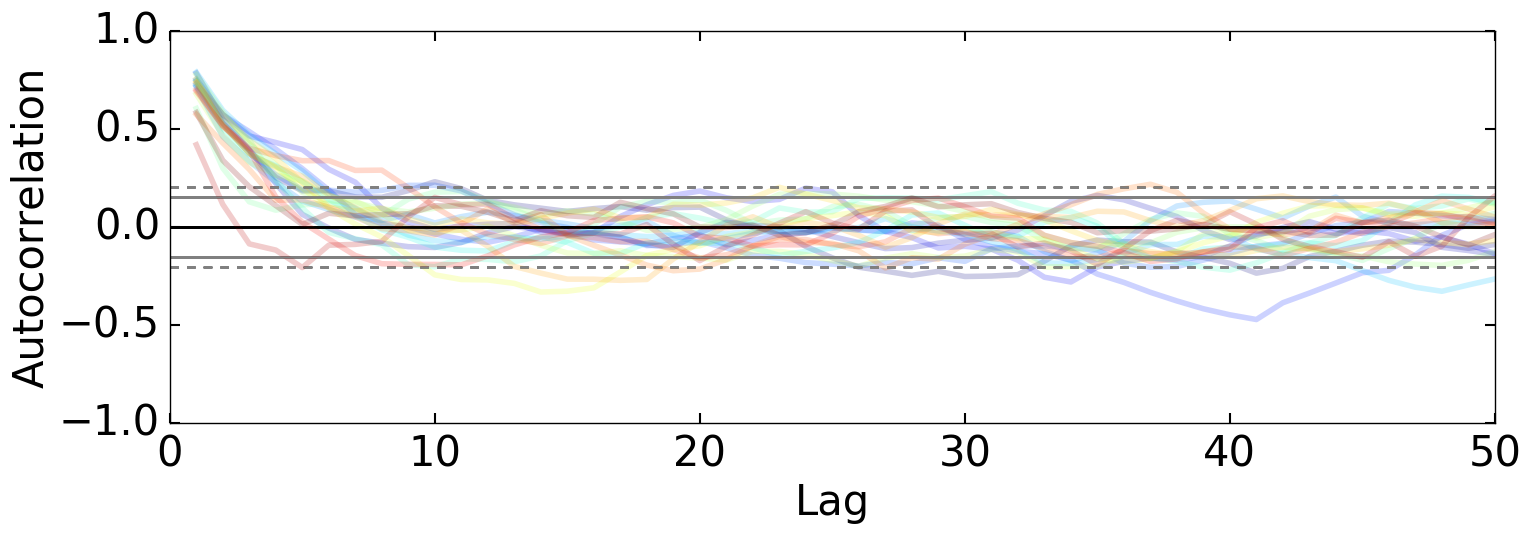

In [35]:
Nburnin = 40 # burn-in
indices = argsort(hier_samples_n[Nburnin:].mean(axis=0))[::-1] # sort from largest to smallest number density

# plot autocorrelation lag
figure(figsize=(16,6))
colors = get_cmap('jet')(linspace(0,1,20))
h = [autocorrelation_plot(hier_samples_n[Nburnin:,indices[i]], color=colors[i], lw=4, alpha=0.2) for i in xrange(20)]
xlim([0, 50])
tight_layout()

Let's look at the traces of a few samples.

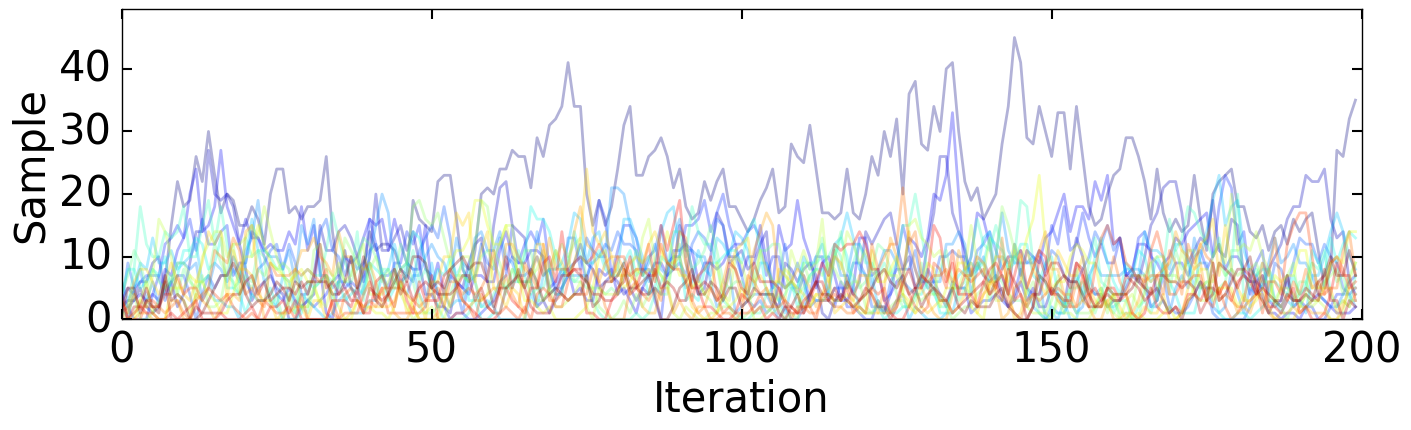

In [36]:
# plot samples
figure(figsize=(16,4))
for i in xrange(20):
    idx = indices[i]
    plot(arange(Nmcmc), hier_samples_n[:,idx], color=colors[i], lw=2, alpha=0.3)
ylim([max(0,hier_samples_n[Nburnin:,indices[:20]].min()-100), hier_samples_n[Nburnin:,indices[:20]].max()*1.1])
xlim([0, Nmcmc])
xlabel('Iteration')
ylabel('Sample')

In [37]:
# thinning
Nthin = 8
hier_samples_t = hier_samples_n[Nburnin::Nthin]

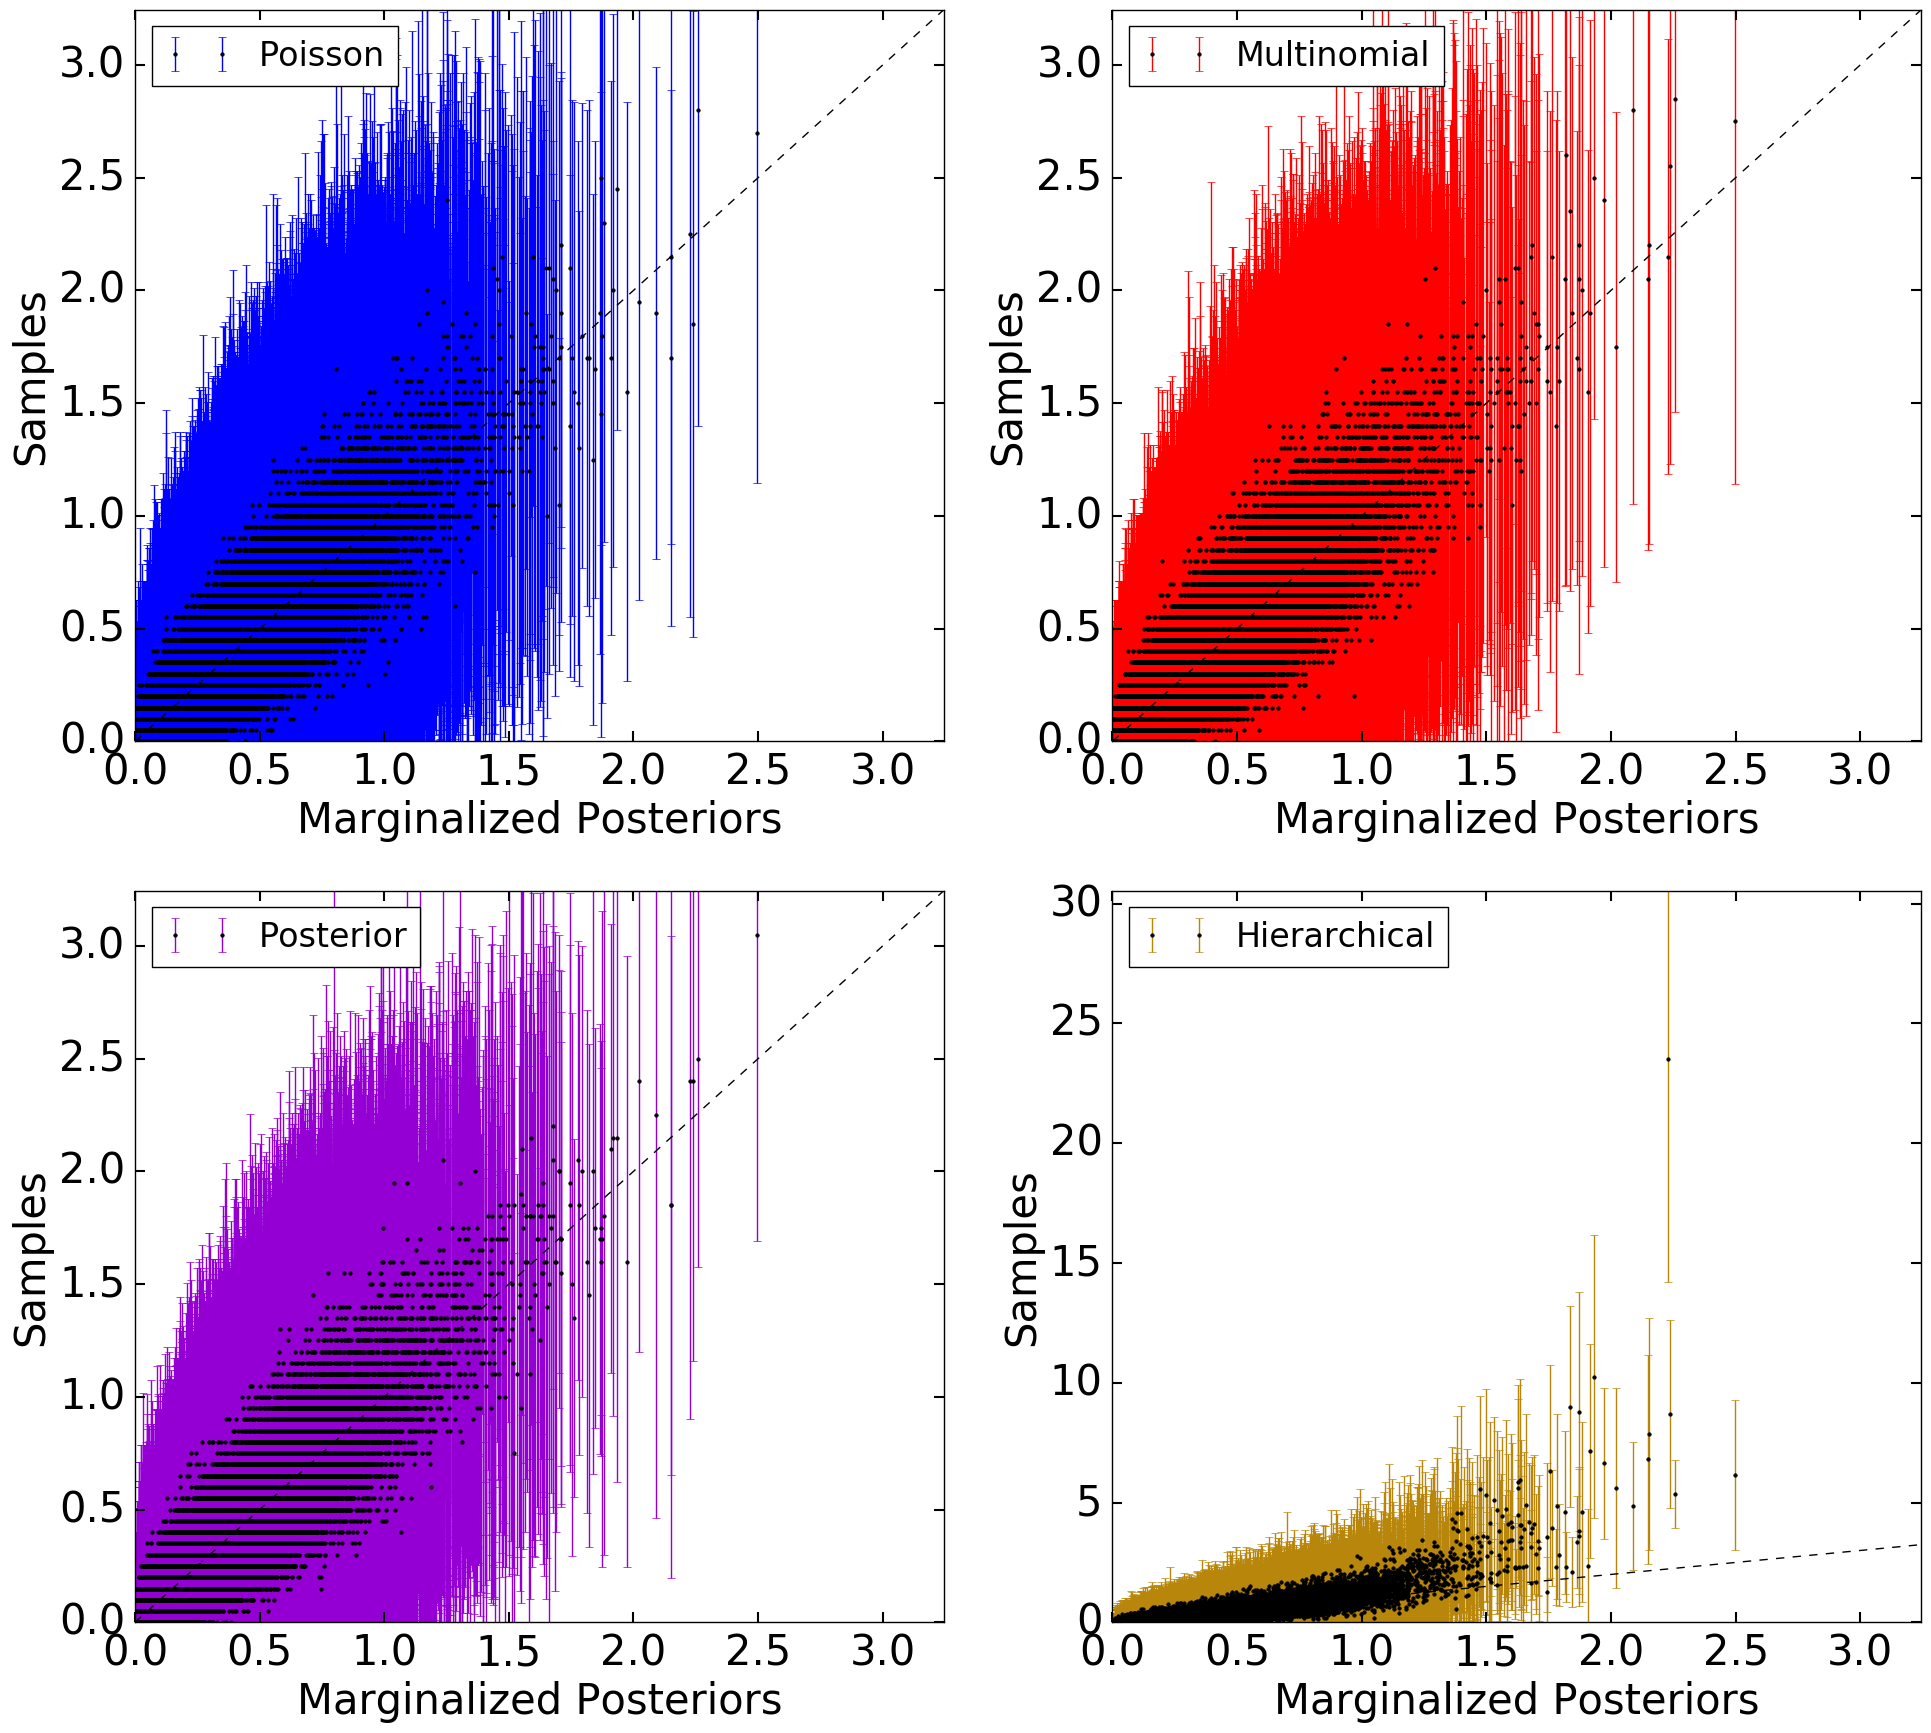

In [38]:
# plotting
figure(figsize=(20,18))
subplot(2,2,1)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, pois_samples.mean(axis=0), fmt='k.', yerr=pois_samples.std(axis=0), ecolor='blue', markersize=5, lw=1, 
         label='Poisson')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(2,2,2)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, mult_samples.mean(axis=0), fmt='k.', yerr=mult_samples.std(axis=0), ecolor='red', markersize=5, lw=1,
         label='Multinomial')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(2,2,3)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, post_samples.mean(axis=0), fmt='k.', yerr=post_samples.std(axis=0), ecolor='darkviolet', markersize=5, lw=1,
         label='Posterior')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(2,2,4)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, hier_samples_t.mean(axis=0), fmt='k.', yerr=hier_samples_t.std(axis=0), 
         ecolor='darkgoldenrod', markersize=5, lw=1,
         label='Hierarchical')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, hier_samples_t.mean(axis=0).max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()

As expected, our hierarchical model significantly affects the distribution of our population weights compared to our simple conditional case. Let's see how this translates over to our redshift estimates.

In [39]:
# draw redshift samples
hier_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], hier_samples_t[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    hier_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    hier_samples_z[i] *= (Ntest / hier_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

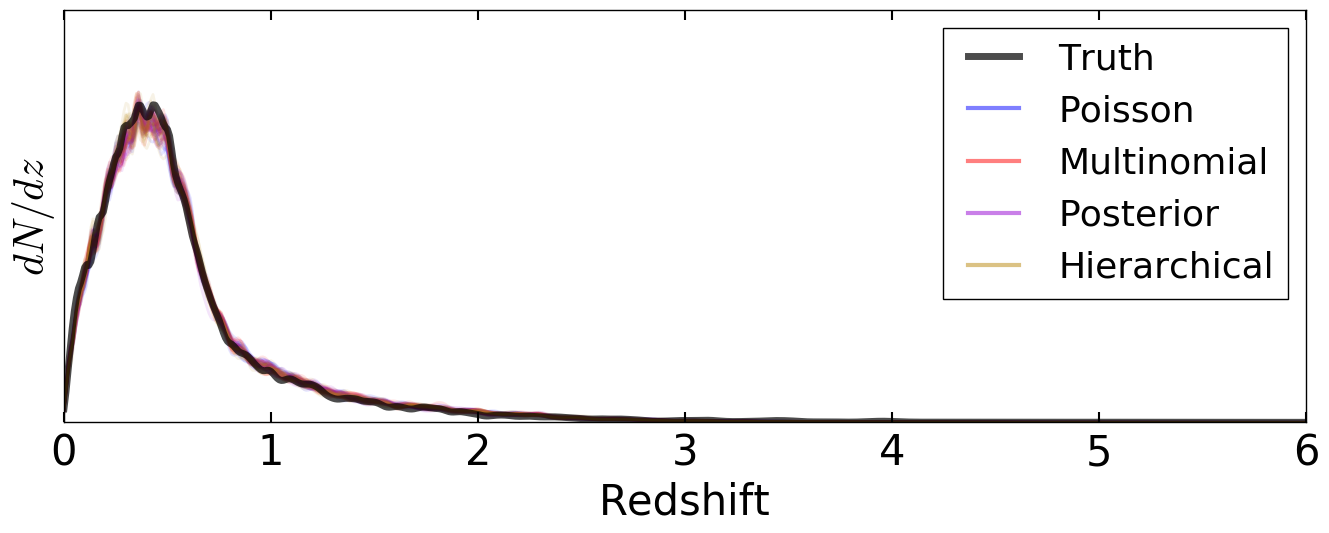

In [40]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, pois_samples_z[i], lw=2, color='blue', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, mult_samples_z[i], lw=2, color='red', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, post_samples_z[i], lw=2, color='darkviolet', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, hier_samples_z[i], lw=2, color='darkgoldenrod', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Multinomial')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Posterior')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.3])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

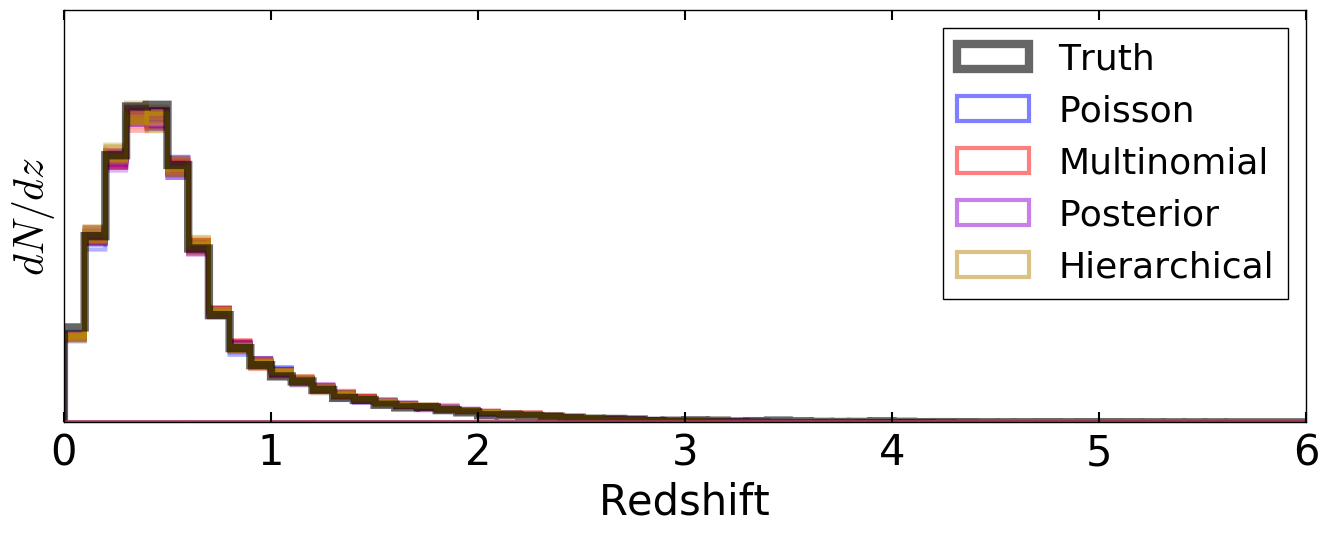

In [41]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=pois_samples_z[i], lw=3, histtype='step', color='blue', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=mult_samples_z[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=post_samples_z[i], lw=3, histtype='step', color='darkviolet', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=hier_samples_z[i], lw=3, histtype='step', color='darkgoldenrod', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='blue', alpha=0.5, label='Poisson')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Multinomial')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='darkviolet', alpha=0.5, label='Posterior')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
xlim([zgrid.min(), zgrid.max()])
yticks([])
ylim([0, max(h[0]) * 1.3])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

Let's also take a look at the posterior $N(z|\mathbf{g})$ samples in two redshift bins to see how the covariance structure changes.

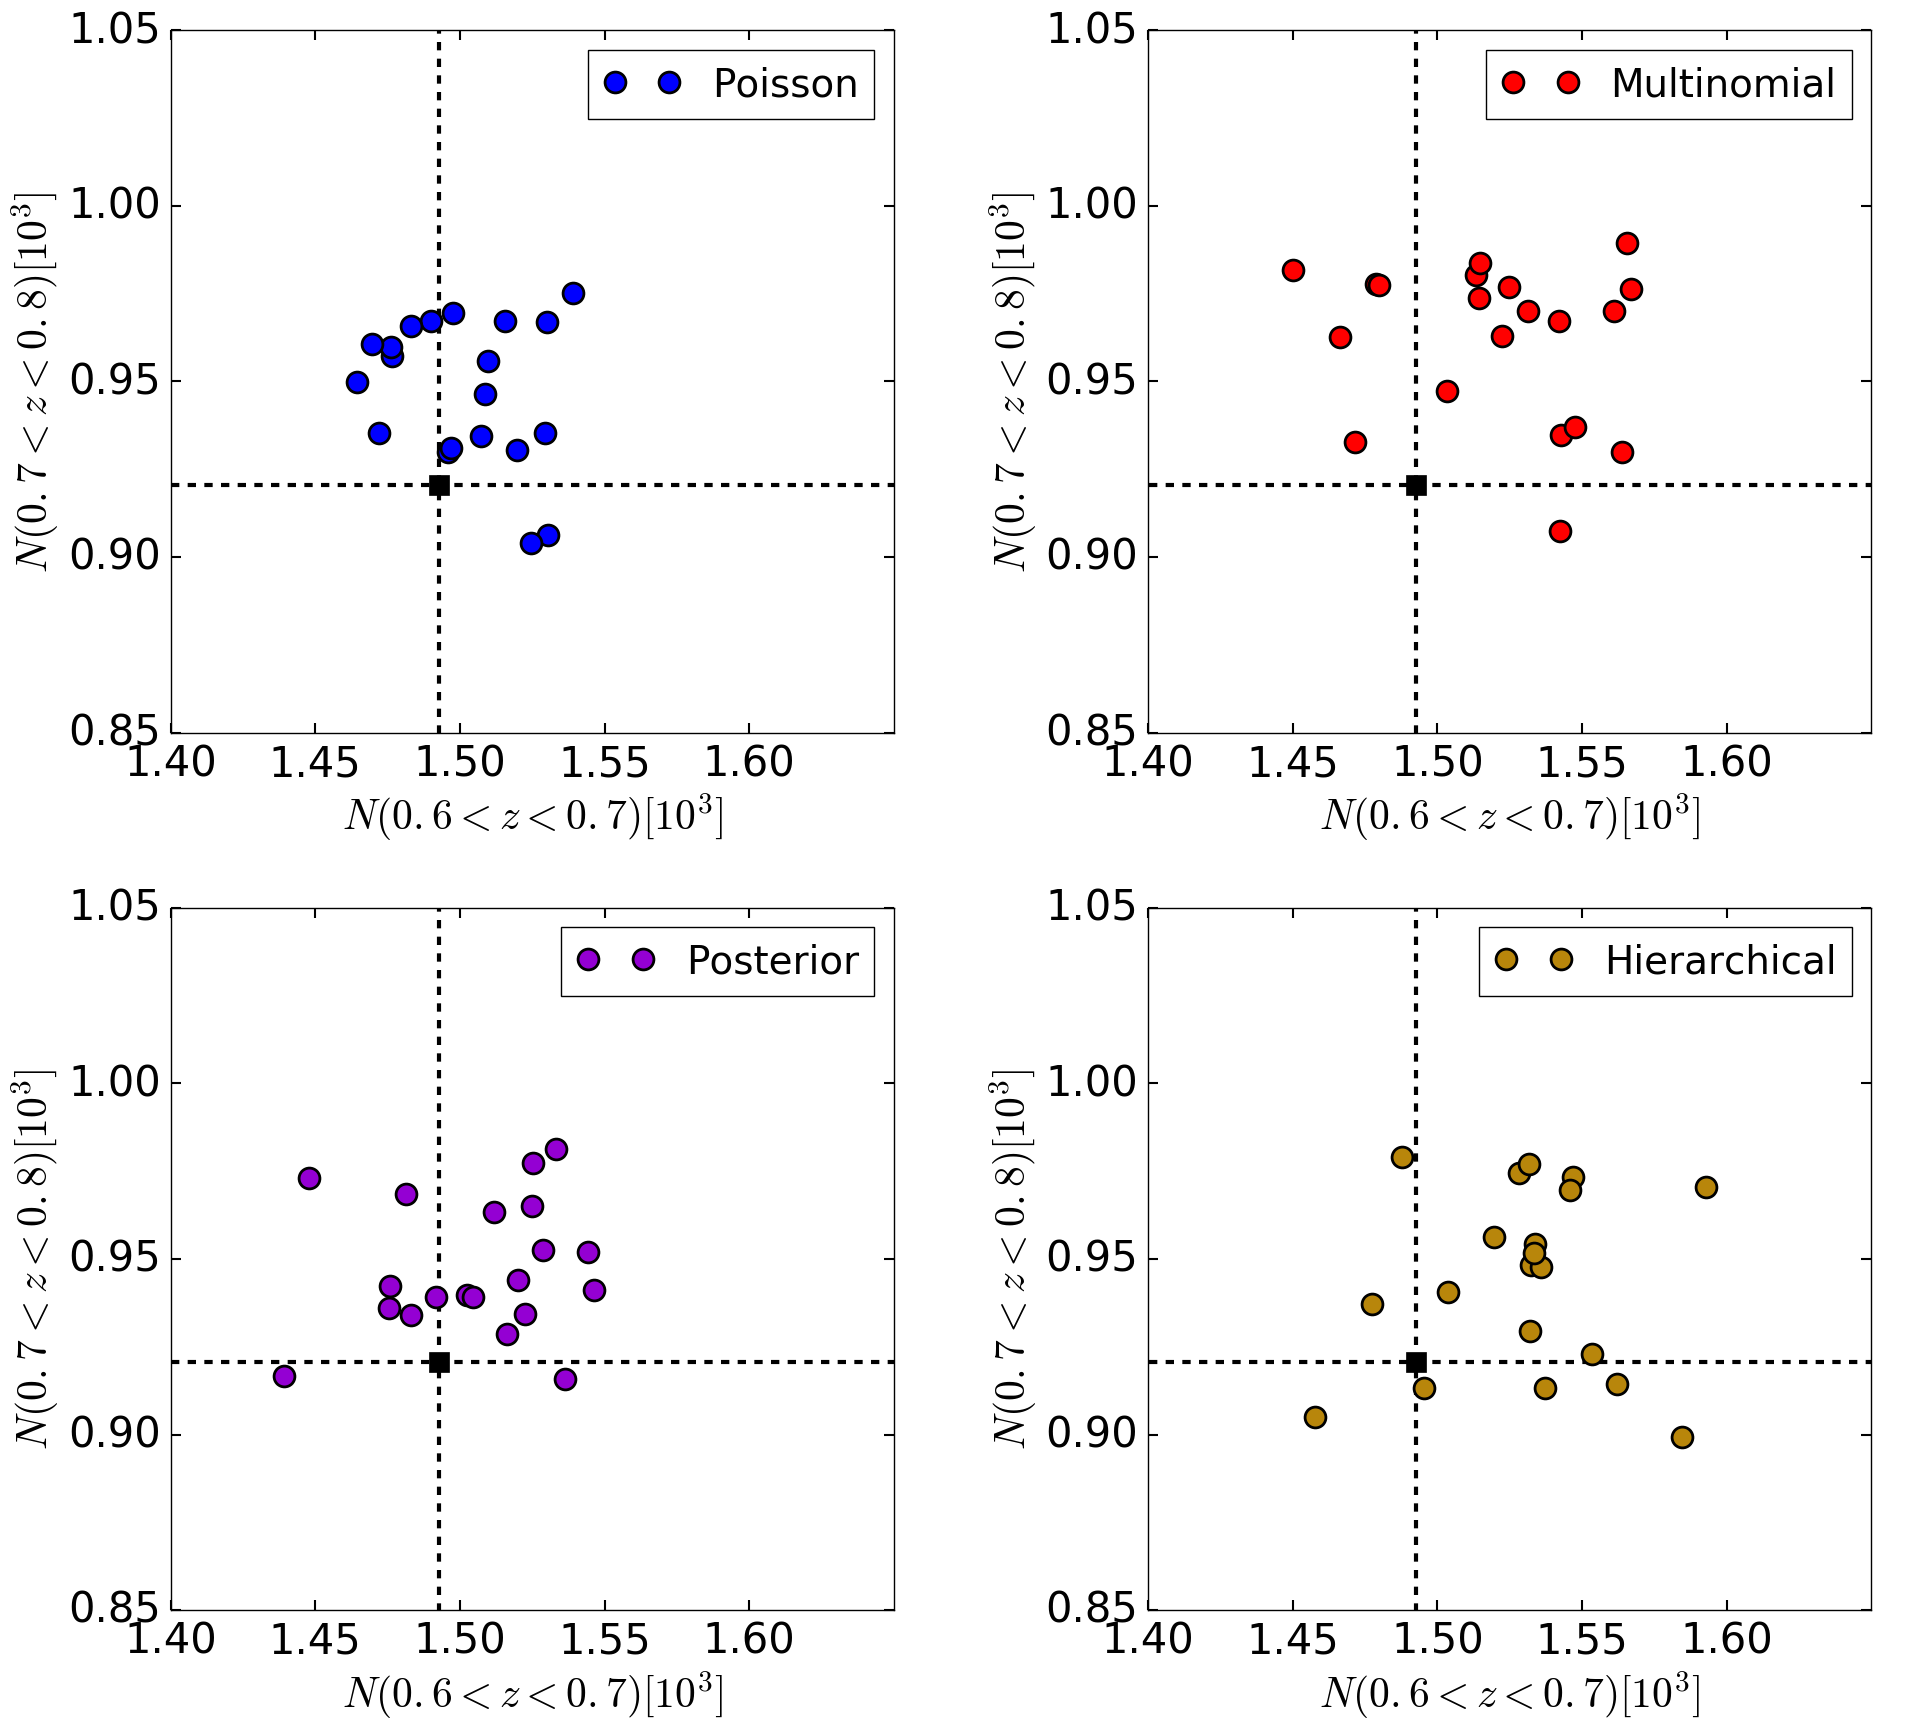

In [47]:
figure(figsize=(20,18))
subplot(2,2,1)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(pois_samples_z[:,60:70].sum(axis=1)/1e3, pois_samples_z[:,70:80].sum(axis=1)/1e3, 'o', color='blue', 
     label='Poisson', markersize=15, markeredgewidth=2)
ylim([0.85, 1.05])
xlim([1.4, 1.65])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,2)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(mult_samples_z[:,60:70].sum(axis=1)/1e3, mult_samples_z[:,70:80].sum(axis=1)/1e3, 'o', color='red', 
     label='Multinomial', markersize=15, markeredgewidth=2)
ylim([0.85, 1.05])
xlim([1.4, 1.65])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,3)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(post_samples_z[:,60:70].sum(axis=1)/1e3, post_samples_z[:,70:80].sum(axis=1)/1e3, 'o', color='darkviolet', 
     label='Posterior', markersize=15, markeredgewidth=2)
ylim([0.85, 1.05])
xlim([1.4, 1.65])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,4)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(hier_samples_z[:,60:70].sum(axis=1)/1e3, hier_samples_z[:,70:80].sum(axis=1)/1e3, 'o', 
     color='darkgoldenrod', label='Hierarchical', markersize=15, markeredgewidth=2)
ylim([0.85, 1.05])
xlim([1.4, 1.65])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()

## Individual Posteriors

Up until this point, we've mostly just looked at how hierarchical inference affects our population distribution. However, it also modifies individual photo-z PDFs. We take a look at a couple of these below.

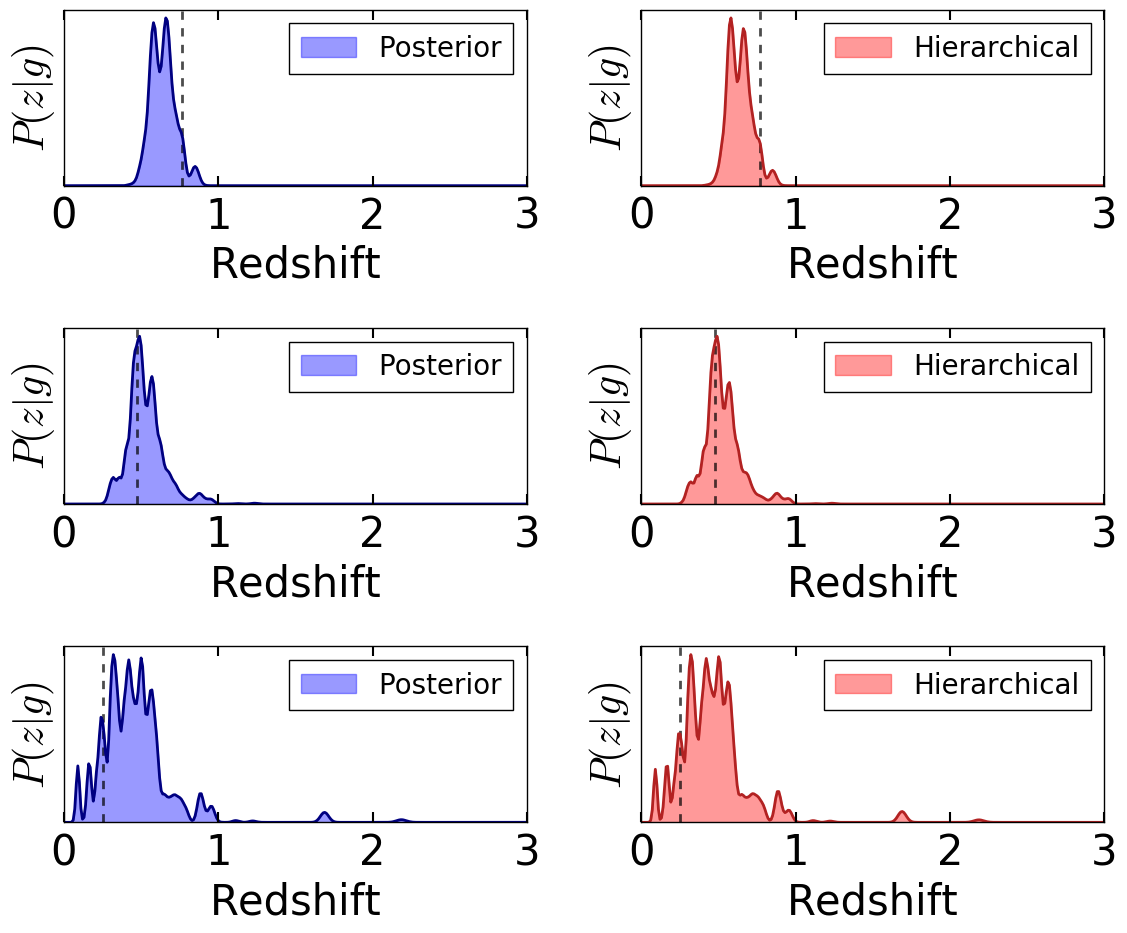

In [50]:
# plotting
indices = choice(Ntest, size=3, replace=False)

# testing
figure(figsize=(12,10))
for i in xrange(3):
    idx = indices[i]
    Nm = model_Nobj[idx]
    midx, post = model_obj[idx,:Nm], model_post[idx,:Nm]
    hier_post = post * hier_samples_w[Nburnin::Nthin,midx]
    hier_post /= hier_post.sum(axis=1)[:,None]
    hier_post = hier_post.sum(axis=0)/Nsamples
    subplot(3,2,2*i+1)
    pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel[midx]], lzeidx[train_sel[midx]], post,
                          rdict.grid, rdict.delta, Nm, rdict.Ngrid) # smooth PDF generated using input dictionaries
    pdf = pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
    pdf = interp(zgrid, rdict.zgrid_highres, pdf) # resampling
    pdf /= pdf.sum() # normalizing
    plot(zgrid, pdf, lw=2, color='navy')
    fill_between(zgrid, pdf, color='blue', alpha=0.4, label='Posterior')
    vlines(redshifts[test_sel][idx], 0, 1e2, colors='black', linestyles='--', lw=2, alpha=0.7)
    xlabel('Redshift')
    xlim([0,3])
    xticks(arange(4))
    ylabel('$P(z|g)$')
    ylim([None, pdf.max()*1.05])
    yticks([])
    legend(fontsize=20)
    tight_layout()
    subplot(3,2,2*i+2)
    pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel[midx]], lzeidx[train_sel[midx]], hier_post,
                          rdict.grid, rdict.delta, Nm, rdict.Ngrid) # smooth PDF generated using input dictionaries
    pdf = pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
    pdf = interp(zgrid, rdict.zgrid_highres, pdf) # resampling
    pdf /= pdf.sum() # normalizing
    plot(zgrid, pdf, lw=2, color='firebrick')
    fill_between(zgrid, pdf, color='red', alpha=0.4, label='Hierarchical')
    vlines(redshifts[test_sel][idx], 0, 1e2, colors='black', linestyles='--', lw=2, alpha=0.7)
    xlabel('Redshift')
    xlim([0,3])
    xticks(arange(4))
    ylabel('$P(z|g)$')
    ylim([None, pdf.max()*1.05])
    yticks([])
    legend(fontsize=20)
    tight_layout()

## Incorporating Selection Effects

We now want to see if incorporating selection effects (from Part 3.3) improves our results by giving more accurate posteriors.

In [51]:
Ntest = len(phot_test) # reset Ntest

In [52]:
model_ll2 = model_ll.copy() # new conditional likelihoods

fcut_test = err_test[:,2]*10. # selection boundary (testing objects)
fcut_train = err_train[:,2]*2. # selection boundary (training objects)

for i in xrange(Ntest):
    if i%5000==0: sys.stdout.write(str(i)+' ')
    Nm = model_Nobj[i]
    midx = model_obj[i,:Nm]
    ptest, etest, mtest = phot_test[i], err_test[i], mask_test[i]
    ptrain, etrain, etrain_smooth, mtrain = phot_train[midx], err_train[midx], err_train_smooth[midx], mask_train[midx]
    fcut = fcut_train[midx]
    
    # compute other bands as normal
    mtest[2] = False # pretend we have no data in band we've selected on
    model_ll2[i,:Nm] = fz.loglikelihood(ptest, etest, mtest, ptrain, etrain_smooth, mtrain)[0] # compute chi2 - N
    
    # compute conditional likelihood for target object
    x = linspace(ptest[2]-20*etest[2], ptest[2]+5*etest[2], 100) # grid
    y = fz.gaussian(ptest[2], etest[2], x) / (0.5*special.erfc((fcut_test[i] - x)/(sqrt(2)*etest[2]))) # conditional likelihood
    y[~isfinite(y)] = 0. # check for division issues
    y /= trapz(y,x) # normalize
    y[~isfinite(y)] = 0. # re-check for division issues
    
    # compute conditional likelihood for training objects
    yt = array([fz.gaussian(ptrain[j,2], etrain_smooth[j,2], x) 
                / (0.5*special.erfc((fcut[j] - x)/(sqrt(2)*etrain[j,2]))) 
                for j in xrange(Nm)]) # conditional likelihoods
    yt[~isfinite(yt)] = 0. # check for division issues
    yt /= trapz(yt,x)[:,None] # normalize
    yt[~isfinite(yt)] = 0. # re-check for division issues
    
    ll = -2*log(trapz(y*yt,x)) # compute log-likelihoods
    model_ll2[i,:Nm] += ll - 1 # add results back into original log-likelihoods (w/ band normalization)

0 5000 10000 15000 

In [53]:
# compute evidences and posteriors
model_post = zeros(model_ll.shape)
model_evid = zeros(Ntest)
prior = ones(Ntrain) # uniform prior

for i in arange(Ntest):
    Nm = model_Nobj[i] # number of models
    midx = model_obj[i,:Nm] # model indices
    ll = model_ll2[i,:Nm] # log-likelihoods w/ selection effects
    like = exp(-0.5*(ll-ll.min())) # scaled likelihoods
    model_evid[i] = like.sum() * exp(-0.5*ll.min()) # evidence
    post = float64(like * prior[midx]) # scaled posteriors
    post /= post.sum() # normalizing
    model_post[i,:Nm] = post

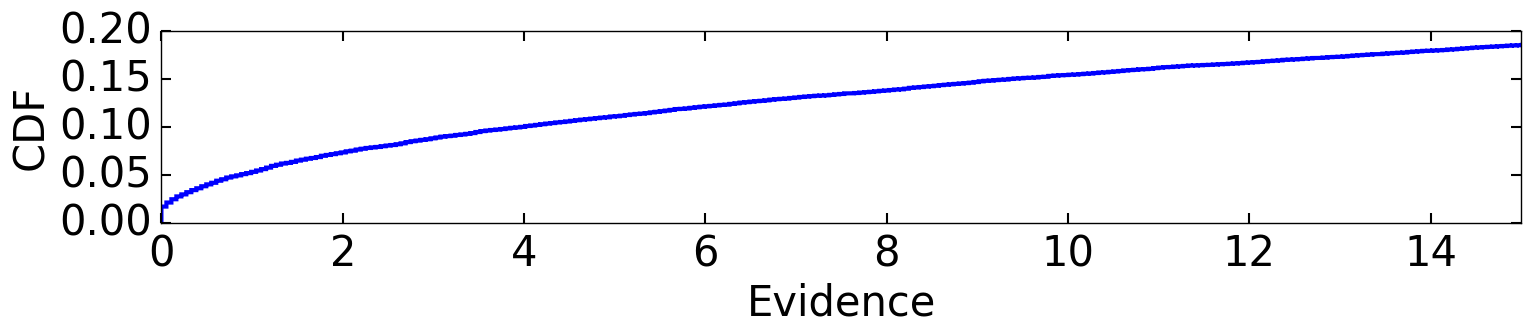

In [55]:
figure(figsize=(16,4))
h = hist(model_evid, 50000, histtype='step', lw=3, normed=True, cumulative=True)
xlabel('Evidence')
xlim([0,15])
ylabel('CDF')
ylim([0,0.2])
tight_layout()

Less objects have enough coverage after including our selection effects.

In [56]:
pmask = arange(len(err_test))[model_evid>10]
Ntest = len(pmask)
print('Objects with reasonable coverage {:}/{:}'.format(Ntest, len(model_evid)))

Objects with reasonable coverage 16922/20000


In [57]:
# computing stacked posteriors
pstack = zeros(Ntrain)
for i in pmask:
    Nm = model_Nobj[i]
    midx = model_obj[i,:Nm]
    pstack[midx] += model_post[i,:Nm] # stacked posterior

In [58]:
# compute redshift PDF (truth)
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[test_sel][pmask], lzeidx[test_sel][pmask], ones(Ntest),
                        rdict.grid, rdict.delta, Ntest, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf = interp(rdict.zgrid_out, rdict.zgrid_highres, z_pdf)
z_pdf /= z_pdf.sum() # normalizing

Let's draw our samples.

In [59]:
pois_samples = array([poisson(pstack) for i in xrange(Nsamples)]) # poisson samples

In [60]:
mult_samples = multinomial(Ntest, pstack/pstack.sum(), size=Nsamples) # multinomial samples

In [61]:
post_samples = zeros((Nsamples, Ntrain), dtype='int') # posterior samples
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    for j in pmask:
        Nm = model_Nobj[j]
        midx = model_obj[j,:Nm]
        post = model_post[j,:Nm]
        post_samples[i,midx] += multinomial(1, post) # sample object

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [62]:
# hierarchical samples
hier_samples_n = zeros((Nmcmc, Ntrain))
hier_samples_w = zeros((Nmcmc, Ntrain))

wt = ones(Ntrain) # initialize weights
for i in xrange(Nmcmc):
    sys.stdout.write(str(i)+' ')
    n = zeros(Ntrain) # number counts
    for j in pmask:
        Nm = model_Nobj[j]
        midx = model_obj[j,:Nm]
        post = model_post[j,:Nm] * wt[midx]
        post /= post.sum()
        n[midx] += multinomial(1, post) # stack multinomial draw
    wt = dirichlet(n + 1) * Ntest # sample population weight
    hier_samples_n[i], hier_samples_w[i] = n.copy(), wt.copy()
hier_samples_t = hier_samples_n[Nburnin::Nthin]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

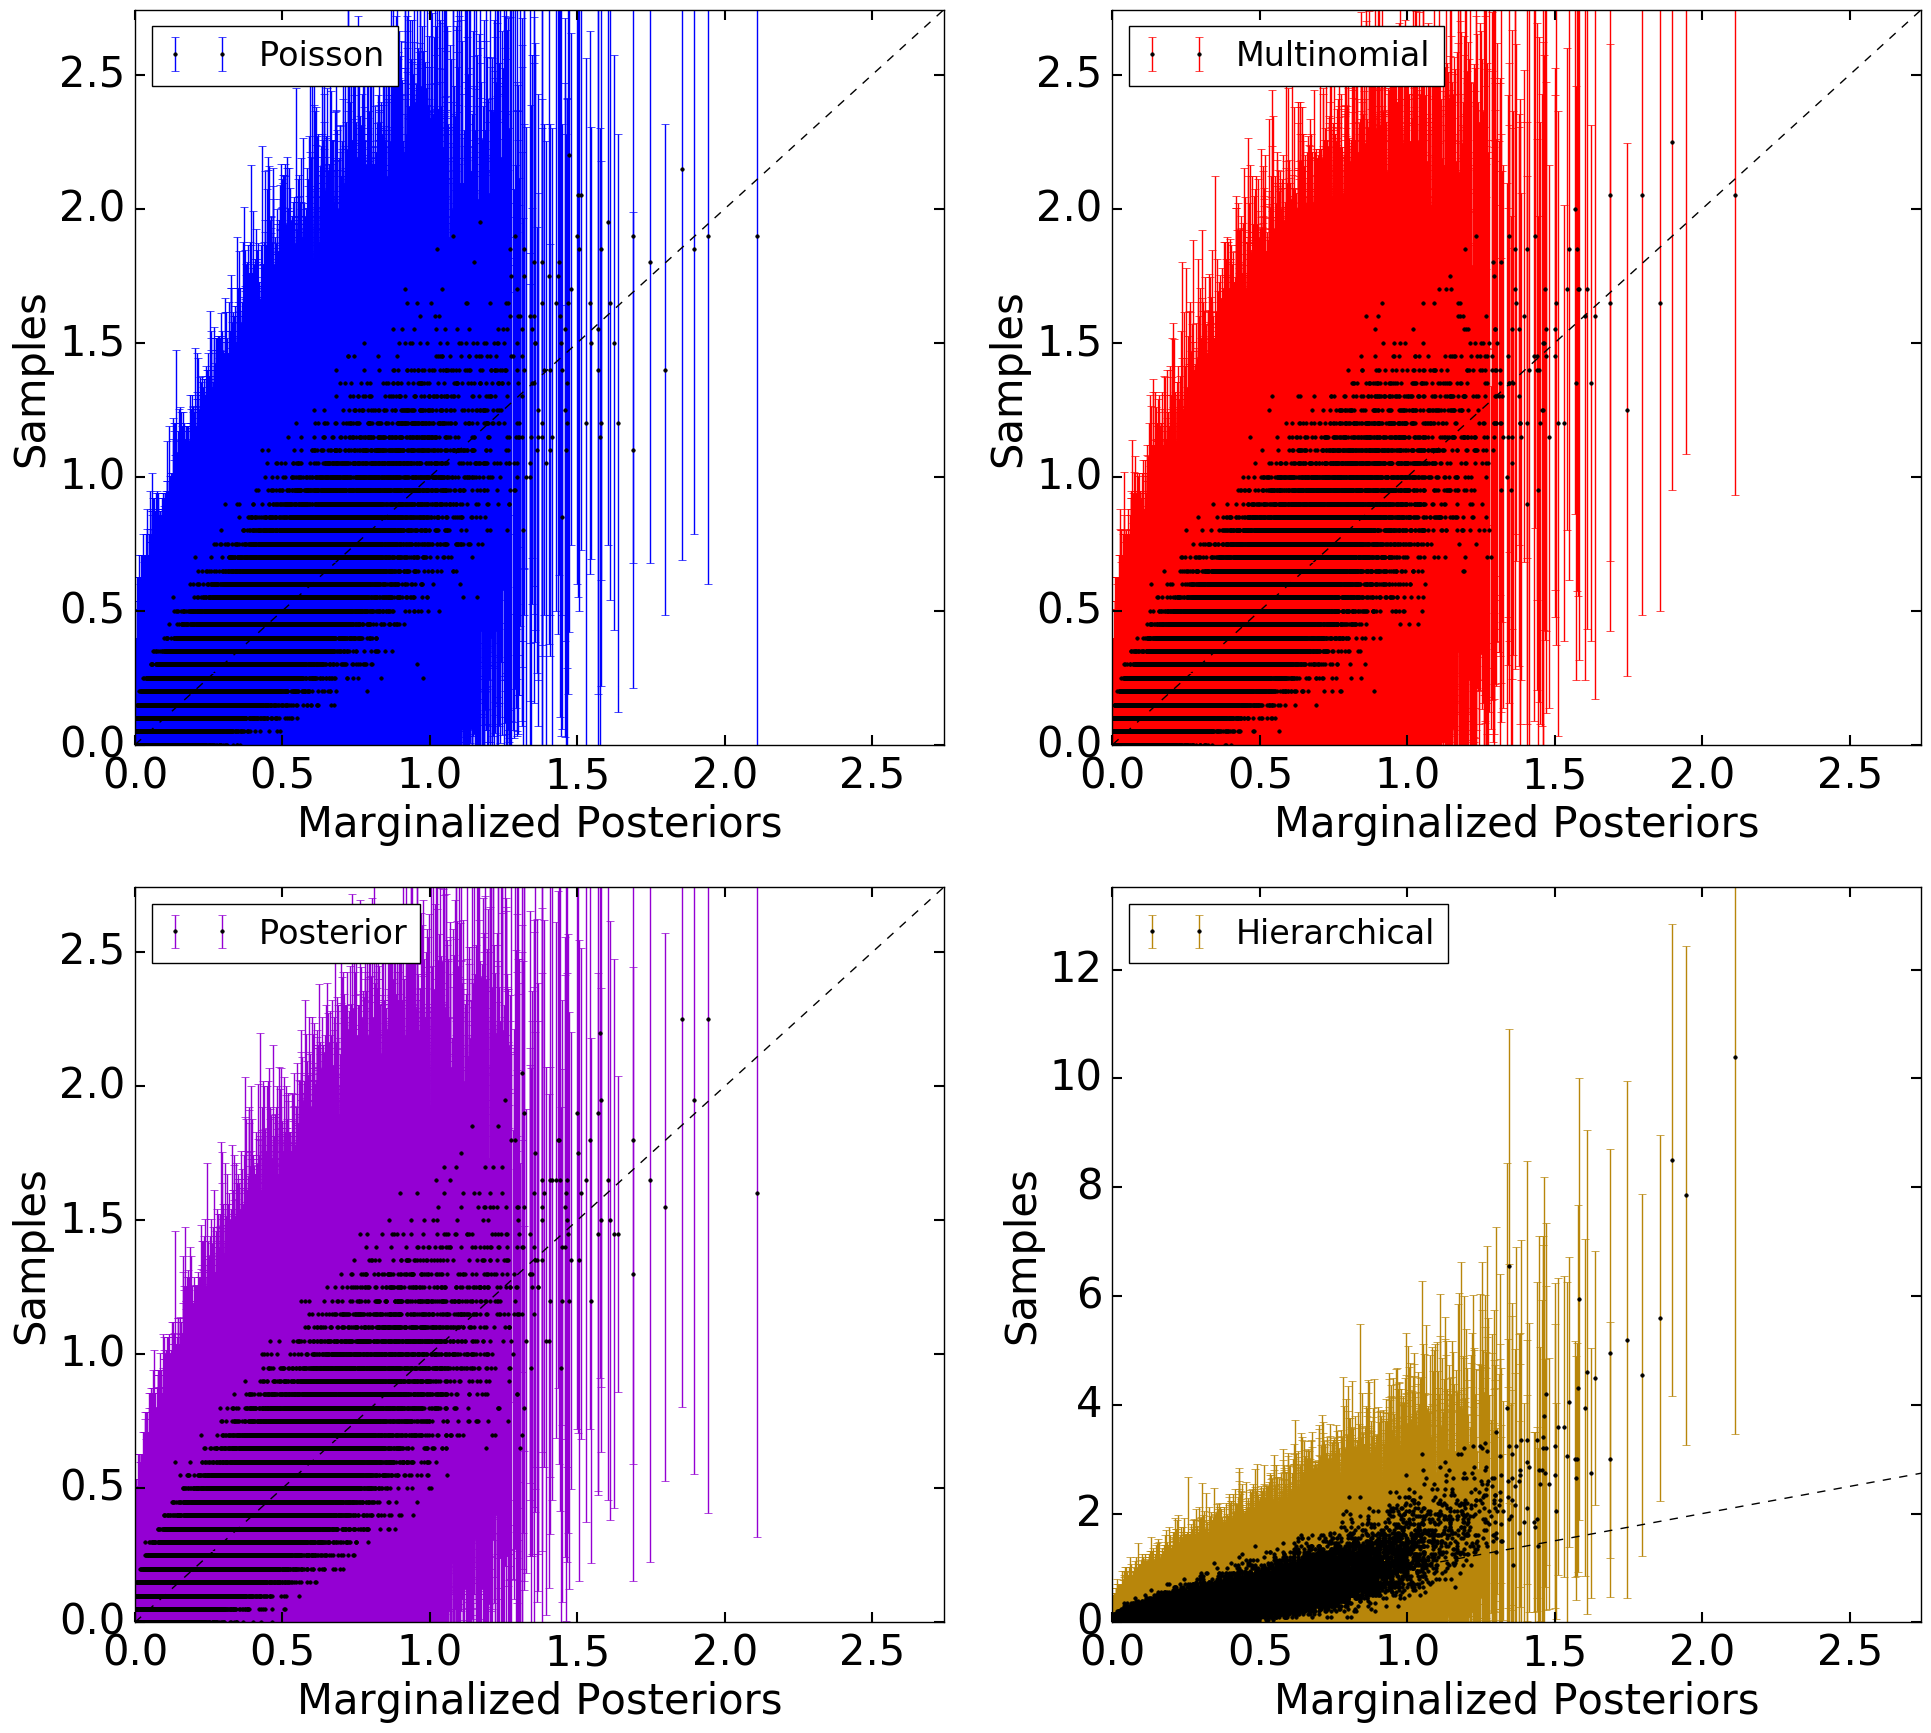

In [63]:
# plotting
figure(figsize=(20,18))
subplot(2,2,1)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, pois_samples.mean(axis=0), fmt='k.', yerr=pois_samples.std(axis=0), ecolor='blue', markersize=5, lw=1, 
         label='Poisson')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(2,2,2)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, mult_samples.mean(axis=0), fmt='k.', yerr=mult_samples.std(axis=0), ecolor='red', markersize=5, lw=1,
         label='Multinomial')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(2,2,3)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, post_samples.mean(axis=0), fmt='k.', yerr=post_samples.std(axis=0), ecolor='darkviolet', markersize=5, lw=1,
         label='Posterior')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(2,2,4)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, hier_samples_t.mean(axis=0), fmt='k.', yerr=hier_samples_t.std(axis=0), 
         ecolor='darkgoldenrod', markersize=5, lw=1,
         label='Hierarchical')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, hier_samples_t.mean(axis=0).max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()

In [64]:
# draw redshift samples

# poisson
pois_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    Nsamps = pois_samples[i].sum()
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], pois_samples[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    pois_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    pois_samples_z[i] *= (Nsamps / pois_samples_z[i].sum()) # normalize
    
# multinomial
mult_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], mult_samples[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    mult_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    mult_samples_z[i] *= (Ntest / mult_samples_z[i].sum()) # normalize
    
# posterior
post_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], post_samples[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    post_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    post_samples_z[i] *= (Ntest / post_samples_z[i].sum()) # normalize
    
# hierarchical
hier_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], hier_samples_t[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    hier_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    hier_samples_z[i] *= (Ntest / hier_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

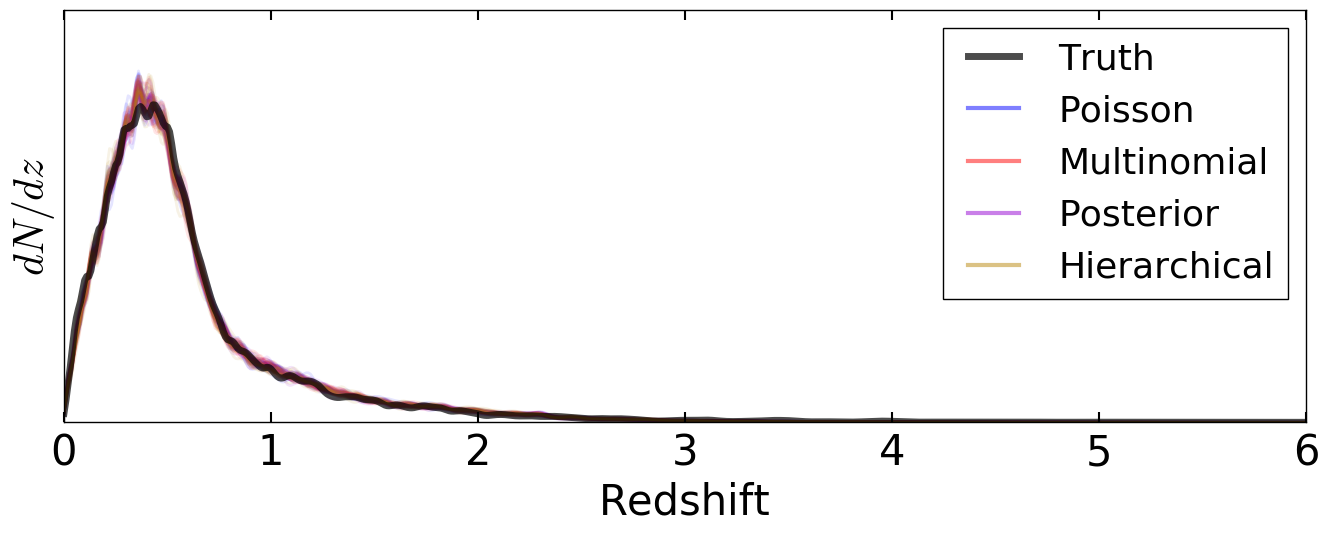

In [65]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, pois_samples_z[i], lw=2, color='blue', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, mult_samples_z[i], lw=2, color='red', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, post_samples_z[i], lw=2, color='darkviolet', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, hier_samples_z[i], lw=2, color='darkgoldenrod', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='blue', alpha=0.5, label='Poisson')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Multinomial')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='darkviolet', alpha=0.5, label='Posterior')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.3])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

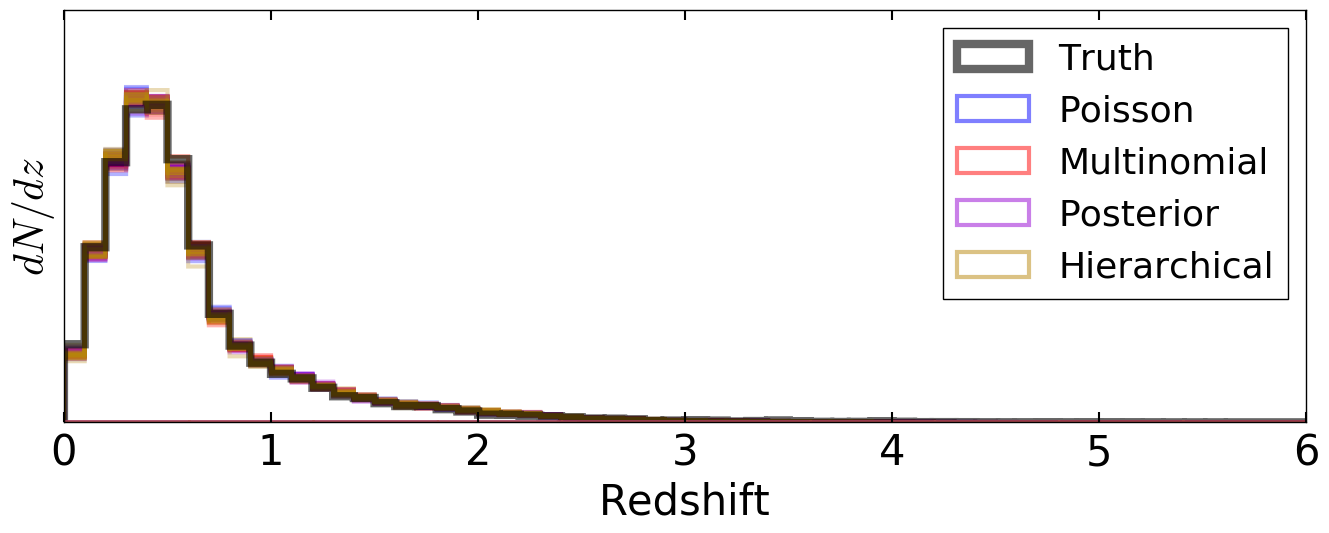

In [66]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=pois_samples_z[i], lw=3, histtype='step', color='blue', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=mult_samples_z[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=post_samples_z[i], lw=3, histtype='step', color='darkviolet', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=hier_samples_z[i], lw=3, histtype='step', color='darkgoldenrod', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='blue', alpha=0.5, label='Poisson')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Multinomial')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='darkviolet', alpha=0.5, label='Posterior')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
xlim([zgrid.min(), zgrid.max()])
yticks([])
ylim([0, max(h[0]) * 1.3])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

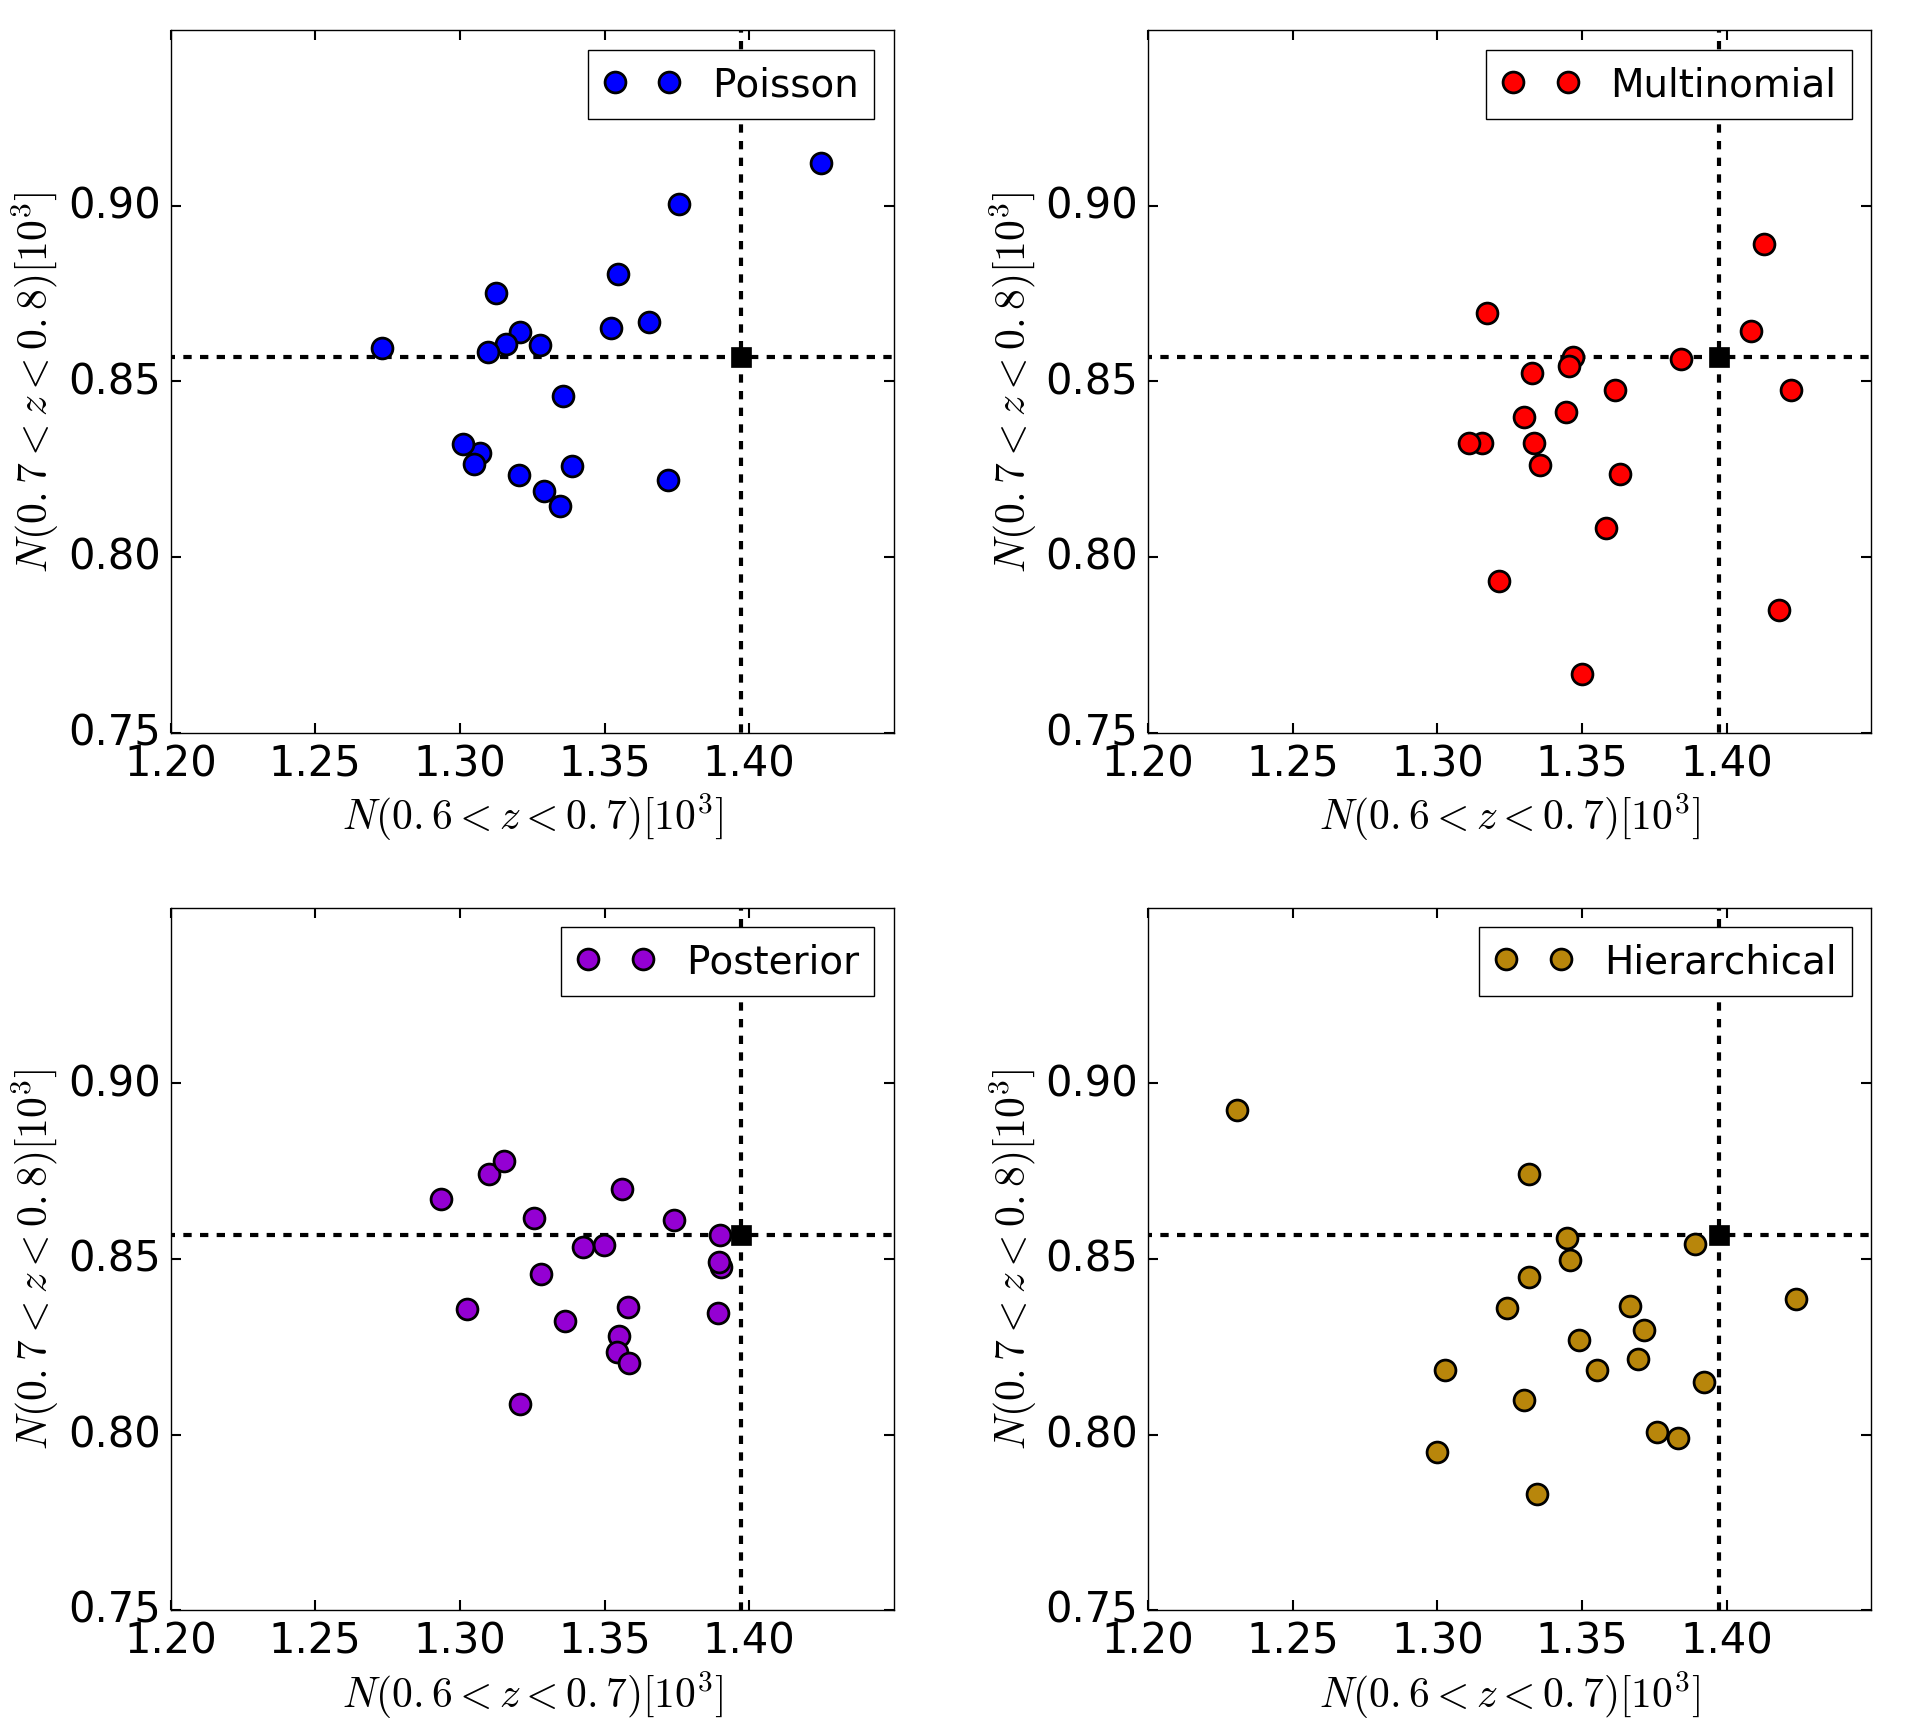

In [71]:
figure(figsize=(20,18))
subplot(2,2,1)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(pois_samples_z[:,60:70].sum(axis=1)/1e3, pois_samples_z[:,70:80].sum(axis=1)/1e3, 'o', color='blue', 
     label='Poisson', markersize=15, markeredgewidth=2)
ylim([0.75, 0.95])
xlim([1.2, 1.45])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,2)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(mult_samples_z[:,60:70].sum(axis=1)/1e3, mult_samples_z[:,70:80].sum(axis=1)/1e3, 'o', color='red', 
     label='Multinomial', markersize=15, markeredgewidth=2)
ylim([0.75, 0.95])
xlim([1.2, 1.45])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,3)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(post_samples_z[:,60:70].sum(axis=1)/1e3, post_samples_z[:,70:80].sum(axis=1)/1e3, 'o', color='darkviolet', 
     label='Posterior', markersize=15, markeredgewidth=2)
ylim([0.75, 0.95])
xlim([1.2, 1.45])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(2,2,4)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(hier_samples_z[:,60:70].sum(axis=1)/1e3, hier_samples_z[:,70:80].sum(axis=1)/1e3, 'o', 
     color='darkgoldenrod', label='Hierarchical', markersize=15, markeredgewidth=2)
ylim([0.75, 0.95])
xlim([1.2, 1.45])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()

We see that incorporating our selection effects into our posteriors appears to give better estimates of the underlying distribution both with and without additional hierarchical modeling. This appears at odds with our results from Part 3.3, where we found our posteriors were possibly "over"-corrected. 

Here we can now pinpoint exactly where that effect is coming from: objects with a lack of sufficient coverage to have reliable posteriors. Including selection effects in general decreases the coverage of any particular object by broadening all of the training/target flux PDFs used in our fits. Since this can significantly affect the relative log-likelihoods for objects with low coverage (which on average are brighter, since that region of color-magnitude space is more sparsely populated), this biases us towards brighter objects for which the original log-likelihoods become less dispersed. Removing these objects from our analysis thus removes the majority of this type of bias. 

The improved performance on our evidence-cleaned sample thus indicates that we actually do a better job probing the true posteriors for objects with good coverage! So incorporating these effects is a bit of a double-edged sword: we will tend to do worse on objects with little coverage (often brighter), but better on objects with good coverage.